# Set up

In [ ]:
#import jax.numpy as np
#from jax import jit, random, vmap
#from jax.ops import index_add, index_update, index
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FuncFormatter)
from matplotlib.lines import Line2D
import functools
from scipy.special import gamma
from scipy.stats import binom_test
import numpy as np
import pickle
from tabulate import tabulate
import calendar
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
mainDirectory = '/content/gdrive/My Drive/COVID19 Eviction Modeling/'

In [ ]:
avgHHsize = 2.45 # used to get total evictions
IFR = 0.01 # used to get deaths
thisEvictRate = 1.0
thisFileEvict="evict1_0" # case to use for comparison all trajectories

In [ ]:
c1Tint = 57
c2Tint = 50
c3Tint= 38
c4Tint= 38
highSARc1Tint = 54
lowSAReqWc1Tint = 56
eqWc1Tint = 60

demes2c1Tint = 57
demes2c1Tintpm = 58

#ranges for plotting
upCI=95
loCI=5

pop = int(1e6) #Population of city

In [ ]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('lines',linewidth=2)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE, frameon=False)    # legend fontsize
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors) # color scheme

## Functions

In [ ]:
def import_data(thisFolder):

  # import files of interest

  # import baseline case
  thisFile="baseline"

  dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
  file = open(dataFile, 'rb')
  soln = pickle.load(file)
  file.close()

  dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
  file = open(dataFile, 'rb')
  soln_cum = pickle.load(file)
  file.close()

  dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
  file = open(dataFile, 'rb')
  tvec = pickle.load(file)
  file.close()

  #import eviction case

  thisFile=thisFileEvict

  dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
  file = open(dataFile, 'rb')
  soln_evict = pickle.load(file)
  file.close()

  dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
  file = open(dataFile, 'rb')
  soln_cum_evict = pickle.load(file)
  file.close()

  dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
  file = open(dataFile, 'rb')
  tvec_evict = pickle.load(file)
  file.close()

  #import the summary table

  dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
  finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=1)

  return soln, soln_cum, tvec, soln_evict, soln_cum_evict, tvec_evict, finalsize

In [ ]:
def get_daily_iter(soln_cum,tvec):

  """
  Calculates daily incidence for multiple runs
  soln_cum: 2D array of cumulative values for each variable at each timepoint
  tvec: 1D vector of timepoints
  """
  
  Tmax=int(tvec[-1])
  delta_t=tvec[1]-tvec[0]
  total_steps=int(Tmax/delta_t)

  # get daily incidence

  per_day=int(round(1/delta_t)) # number of entries per day
  days_ind=np.arange(start=0,stop=total_steps,step=per_day)

  soln_inc=np.zeros((np.shape(soln_cum)[0],Tmax-1,np.shape(soln_cum)[2]))

  for i in range(0,7):
    daily_cumulative_history=soln_cum[:,days_ind,i] # first pick out entries corresponding to each day
    #soln_inc=index_add(soln_inc,index[:,:,i],daily_cumulative_history[:,1:Tmax]-daily_cumulative_history[:,0:(Tmax-1)]) # then get differences between each day
    soln_inc[:,:,i]=soln_inc[:,:,i]+daily_cumulative_history[:,1:Tmax]-daily_cumulative_history[:,0:(Tmax-1)] # then get differences between each day
  return soln_inc


In [ ]:
def smooth_timecourse(soln,o):
  """
  replaces each entry with the moving average over time
  soln: solution vector, 3D array, to smooth. Assumes time is second dimension
  o: # of days (entries) on either side of the current value to average over. o=3 -> 1 week
  """
  soln_smooth=soln
  for iter in range(np.shape(soln)[0]):
    for var in range(np.shape(soln)[2]):
      z=moving_average(soln[iter,:,var],1)
      #soln_smooth=index_update(soln_smooth,index[iter,:,var],z)
      soln_smooth[iter,:,var]=z
  return soln_smooth

def moving_average(x, o):
  """
  x: array to take moving average og
  o: # of days (entries) on either side of the current value to average over
  """
  w=o*2+1 # width of window to average over, current day in center of window
  y=np.convolve(x, np.ones(w), 'full')
  den=np.concatenate((np.arange(o+1,w),w*np.ones(len(x)-w+1),np.arange(w-1,o,step=-1)))
  z=y[o:-o]/den
  return z

In [ ]:
 def plot_prevalence_all(ymax=0.01,intOn=1,Tint=50,relax=0,Trelax=2*30,lock2=0,Tlock2=5*30,evict=1,T_start_merge=90,T_int_merge = 30,number_merges = 6): 
  
  # Plot average trajectory with and without evictions

  scale=1

  # Tint: Time lockdown starts
  # relax : 0 or 1 if relaxation occurs
  # Trelax : time of relaxation post intervention
  # lock2 : 0 or 1 of second lockdown occurs
  # Tlock2 : time of second lockdown, post relaxation
  # evict: 0 or 1 to plot eviction times
  # number_merges : number of months of evictions after the first
  #T_start_merge : time after last intervention that mergers start (days)
  #T_int_merge : interval between merges (days)

  Trelax=Tint+Trelax
  Tlock2=Trelax+Tlock2

  if relax==1:
    T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)
  else:
    T_merge_vec=np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

  soln_avg=np.average(soln,axis=0)
  soln_loCI=np.percentile(soln,loCI,axis=0)
  soln_upCI=np.percentile(soln,upCI,axis=0)

  soln_evict_avg=np.average(soln_evict,axis=0)
  soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
  soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

  # log scale

  plt.figure(figsize=(2.5*6.4, 4.0))
  plt.subplot(121)

  # add averages
  plt.plot(tvec,soln_avg*scale)
  plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  for i in range(0,7):
    plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)

  # add post eviction on top
  plt.plot(tvec,soln_evict_avg*scale,':')
  for i in range(0,7):
    plt.fill_between(tvec,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)

  if evict==1:
    for i in range(0,number_merges+1):
      plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,scale],'--',color='gray')

  if intOn==1:
    plt.plot([Tint,Tint],[scale/pop,scale],'k--')

  if relax==1:
    plt.plot([Trelax,Trelax],[scale/pop,scale],'k--')

  if lock2==1:
    plt.plot([Tlock2,Tlock2],[scale/pop,scale],'k--')

  plt.ylim([scale/pop,scale])
  plt.xlabel("Time (days)")
  plt.ylabel("Prevalence")
  plt.semilogy()

  plt.subplot(122)
  scale=100
  ymin=0
  plt.plot(tvec,soln_avg*scale)
  plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  for i in range(0,7):
    plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)


  # add post eviction on top
  plt.plot(tvec,soln_evict_avg*scale,':')
  for i in range(0,7):
    plt.fill_between(tvec,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)

  if evict==1:
    for i in range(0,number_merges+1):
      plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

  if intOn==1:
    plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

  if relax==1:
    plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

  if lock2==1:
    plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')

  plt.ylim([ymin,ymax*scale])
  plt.xlabel("Time (days)")
  plt.ylabel("Prevalence (%)")


  plt.tight_layout()

  # if plotThis==True:
  #   plt.savefig(plotName+'.pdf',bbox_inches='tight')

  plt.show()

In [ ]:
 def plot_prevalence(ymax=0.01,intOn=1,Tint=50,relax=0,Trelax=2*30,lock2=0,Tlock2=5*30,evict=1,T_start_merge=90,T_int_merge = 30,number_merges = 6): 

  # same but for total infected only 

  # Plot average trajectory with and without evictions

  # Tint: Time lockdown starts
  # relax : 0 or 1 if relaxation occurs
  # Trelax : time of relaxation post intervention
  # lock2 : 0 or 1 of second lockdown occurs
  # Tlock2 : time of second lockdown, post relaxation
  # evict: 0 or 1 to plot eviction times
  # number_merges : number of months of evictions after the first
  #T_start_merge : time after last intervention that mergers start (days)
  #T_int_merge : interval between merges (days)

  Trelax=Tint+Trelax
  Tlock2=Trelax+Tlock2

  scale=1

  if relax==1:
    T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)
  else:
    T_merge_vec=np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

  soln_avg=np.average(soln,axis=0)
  soln_loCI=np.percentile(soln,loCI,axis=0)
  soln_upCI=np.percentile(soln,upCI,axis=0)

  soln_evict_avg=np.average(soln_evict,axis=0)
  soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
  soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

  # log scale

  plt.figure(figsize=(2*6.4, 4.0))
  plt.subplot(121)

  # add averages
  plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
  plt.plot(tvec,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':')
  #plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  #for i in range(0,7):
  plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
  plt.fill_between(tvec,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)
 
  if evict==1:
    for i in range(0,number_merges+1):
      plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,scale],'--',color='gray')

  if intOn==1:
    plt.plot([Tint,Tint],[scale/pop,scale],'k--')

  if relax==1:
    plt.plot([Trelax,Trelax],[scale/pop,scale],'k--')
  
  if lock2==1:
    plt.plot([Tlock2,Tlock2],[scale/pop,scale],'k--')

  plt.ylim([scale/pop,scale])
  plt.xlabel("Time (days)")
  plt.ylabel("Prevalence")
  plt.semilogy()

  plt.subplot(122)
  scale=100
  ymin=0
  plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
  plt.plot(tvec,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':') # add post eviction on top

  #plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
  plt.fill_between(tvec,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

  if evict==1:
    for i in range(0,number_merges+1):
      plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

  if intOn==1:
    plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

  if relax==1:
    plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')
  
  if lock2==1:
    plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')

  plt.ylim([ymin,ymax*scale])
  plt.xlabel("Time (days)")
  plt.ylabel("Prevalence (%)")

  plt.tight_layout()

  plt.show()

In [ ]:
 def plot_incidence(ymax=0.001,intOn=1,Tint=50,relax=0,Trelax=2*30,lock2=0,Tlock2=5*30,evict=1,T_start_merge=90,T_int_merge = 30,number_merges = 6): 

  # Plot smoothed incidence

  # Tint: Time lockdown starts
  # relax : 0 or 1 if relaxation occurs
  # Trelax : time of relaxation post intervention
  # lock2 : 0 or 1 of second lockdown occurs
  # Tlock2 : time of second lockdown, post relaxation
  # evict: 0 or 1 to plot eviction times
  # number_merges : number of months of evictions after the first
  #T_start_merge : time after last intervention that mergers start (days)
  #T_int_merge : interval between merges (days)

  Trelax=Tint+Trelax
  Tlock2=Trelax+Tlock2

  soln_inc=get_daily_iter(soln_cum,tvec)
  soln_inc_smooth = smooth_timecourse(soln_inc,3)

  soln_inc_evict=get_daily_iter(soln_cum_evict,tvec)
  soln_inc_evict_smooth = smooth_timecourse(soln_inc_evict,3)

  tvec2=np.arange(1,np.shape(soln_inc)[1]+1)

  # Plot average trajectory with and without evictions

  scale=pop

  if relax==1:
    T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)
  else:
    T_merge_vec=np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

  soln_avg=np.average(soln_inc_smooth,axis=0)
  soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
  soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

  soln_evict_avg=np.average(soln_inc_evict_smooth,axis=0)
  soln_evict_loCI=np.percentile(soln_inc_evict_smooth,loCI,axis=0)
  soln_evict_upCI=np.percentile(soln_inc_evict_smooth,upCI,axis=0)

  # log scale

  plt.figure(figsize=(2*6.4, 4.0))
  plt.subplot(121)

  # add averages
  plt.plot(tvec2,soln_avg[:,2]*scale)
  plt.plot(tvec2,soln_evict_avg[:,2]*scale,':')
  #plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  #for i in range(0,7):
  plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
  plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

  if evict==1:
    for i in range(0,number_merges+1):
      plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,scale],'--',color='gray')

  if intOn==1:
    plt.plot([Tint,Tint],[scale/pop,scale],'k--')

  if relax==1:
    plt.plot([Trelax,Trelax],[scale/pop,scale],'k--')

  if lock2==1:
    plt.plot([Tlock2,Tlock2],[scale/pop,scale],'k--') 

  plt.ylim([scale/pop,scale])
  plt.xlabel("Time (days)")
  plt.ylabel("Daily incidence per million")
  plt.semilogy()

  plt.subplot(122)
  scale=pop
  ymin=0
  plt.plot(tvec2,soln_avg[:,2]*scale)
  plt.plot(tvec2,soln_evict_avg[:,2]*scale,':') # add post eviction on top

  #plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
  plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

  if evict==1:
    for i in range(0,number_merges+1):
      plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

  if intOn==1:
    plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

  if relax==1:
    plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

  if lock2==1:
    plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')

  plt.ylim([ymin,ymax*scale])
  plt.xlabel("Time (days)")
  plt.ylabel("Daily incidence per million")

  plt.tight_layout()

  plt.show()


In [ ]:
 def plot_incidence2(ymax=0.001,intOn=1,Tint=50,relax=0,Trelax=2*30,lock2=0,Tlock2=5*30,evict=1,T_start_merge=90,T_int_merge = 30,number_merges = 6,lockDay = 85): 

  # Plot smoothed incidence only on linear scale

  # Tint: Time lockdown starts
  # relax : 0 or 1 if relaxation occurs
  # Trelax : time of relaxation post intervention
  # lock2 : 0 or 1 of second lockdown occurs
  # Tlock2 : time of second lockdown, post relaxation
  # evict: 0 or 1 to plot eviction times
  # number_merges : number of months of evictions after the first
  #T_start_merge : time after last intervention that mergers start (days)
  #T_int_merge : interval between merges (days)

  Trelax=Tint+Trelax
  Tlock2=Trelax+Tlock2

  soln_inc=get_daily_iter(soln_cum,tvec)
  soln_inc_smooth = smooth_timecourse(soln_inc,3)

  soln_inc_evict=get_daily_iter(soln_cum_evict,tvec)
  soln_inc_evict_smooth = smooth_timecourse(soln_inc_evict,3)

  tvec2=np.arange(1,np.shape(soln_inc)[1]+1)

  scale=pop

  if relax==1:
    T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)
  else:
    T_merge_vec=np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

   # convert so that Day 1 is Jan 1 2020
  # Add (realTint-Tint), where real Tint is the calendar Day lockdown truly occured
  # lockDay = 92: April 1st, time of implementation in simulation
  # lockDay = 85: March 25th, average time of implementation in data

  tvec2 = tvec2 - Tint + lockDay
  T_merge_vec = T_merge_vec - Tint + lockDay
  Trelax = Trelax - Tint + lockDay
  Tlock2 = Tlock2 - Tint + lockDay
  Tint = lockDay
  tvec2 = tvec2/30
  T_merge_vec = T_merge_vec/30
  Tint = Tint/30
  Trelax = Trelax/30
  Tlock2 = Tlock2/30
  
  soln_avg=np.average(soln_inc_smooth,axis=0)
  soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
  soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

  soln_evict_avg=np.average(soln_inc_evict_smooth,axis=0)
  soln_evict_loCI=np.percentile(soln_inc_evict_smooth,loCI,axis=0)
  soln_evict_upCI=np.percentile(soln_inc_evict_smooth,upCI,axis=0)

  # Plot average trajectory with and without evictions

  plt.figure(figsize=(6.4*tvec2[-1]/12, 4.0))
  
  scale=pop
  ymin=0
  plt.plot(tvec2,soln_avg[:,2]*scale)
  plt.plot(tvec2,soln_evict_avg[:,2]*scale,':') # add post eviction on top
  plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().xaxis.set_major_locator(MultipleLocator(2))

  #plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
  plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

  if evict==1:
    for i in range(0,number_merges+1):
      plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

  if intOn==1:
    plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

  if relax==1:
    plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

  if lock2==1:
    plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')

  plt.ylim([ymin,ymax*scale])
  plt.xlim([0,np.ceil(np.max(tvec2))])
  plt.xlabel("Time (months since Jan 1 2020)")
  plt.ylabel("Daily incidence per million")

  plt.tight_layout()

  plt.show()


In [ ]:
 def plot_incidence3(ymax=0.001,intOn=1,Tint=50,lockDay = 85): 

  # Plot smoothed incidence only on linear scale

  # Tint: Time lockdown starts
  # relax : 0 or 1 if relaxation occurs
  # Trelax : time of relaxation post intervention
  # lock2 : 0 or 1 of second lockdown occurs
  # Tlock2 : time of second lockdown, post relaxation
  # evict: 0 or 1 to plot eviction times
  # number_merges : number of months of evictions after the first
  #T_start_merge : time after last intervention that mergers start (days)
  #T_int_merge : interval between merges (days)

  soln_inc=get_daily_iter(soln_cum,tvec)
  soln_inc_smooth = smooth_timecourse(soln_inc,3)

  soln_inc_evict=get_daily_iter(soln_cum_evict,tvec)
  soln_inc_evict_smooth = smooth_timecourse(soln_inc_evict,3)

  tvec2=np.arange(1,np.shape(soln_inc)[1]+1)

  scale=pop

   # convert so that Day 1 is Jan 1 2020
  # Add (realTint-Tint), where real Tint is the calendar Day lockdown truly occured
  # lockDay = 92: April 1st, time of implementation in simulation
  # lockDay = 85: March 25th, average time of implementation in data

  tvec2 = tvec2 - Tint + lockDay
  Tint = lockDay
  tvec2 = tvec2/30
  
  soln_avg=np.average(soln_inc_smooth,axis=0)
  soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
  soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

  soln_evict_avg=np.average(soln_inc_evict_smooth,axis=0)
  soln_evict_loCI=np.percentile(soln_inc_evict_smooth,loCI,axis=0)
  soln_evict_upCI=np.percentile(soln_inc_evict_smooth,upCI,axis=0)

  # Plot average trajectory with and without evictions

  plt.figure(figsize=(6.4*tvec2[-1]/12, 4.0))
  
  scale=pop
  ymin=0
  plt.plot(tvec2,soln_avg[:,2]*scale)
  plt.plot(tvec2,soln_evict_avg[:,2]*scale,':') # add post eviction on top
  plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().xaxis.set_major_locator(MultipleLocator(2))

  #plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
  plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

  plt.ylim([ymin,ymax*scale])
  plt.xlim([0,np.ceil(np.max(tvec2))])
  plt.xlabel("Time (months since Jan 1 2020)")
  plt.ylabel("Daily incidence per million")

  plt.tight_layout()

  plt.show()


In [ ]:
 def plot_incidence_case_death(ymax=0.001,Tint=50, lock2 = 0,lockDay = 85): 

  # Plot smoothed incidence

  if lock2==1:
    xmax = 15
  else:
    xmax = 12

  # Tint: Time lockdown starts

  soln_inc=get_daily_iter(soln_cum,tvec)
  soln_inc_smooth = smooth_timecourse(soln_inc,3)

  tvec2=np.arange(1,np.shape(soln_inc)[1]+1)

   # convert so that Day 1 is Jan 1 2020
  # Add (realTint-Tint), where real Tint is the calendar Day lockdown truly occured
  # lockDay = 92: April 1st, time of implementation in simulation
  # lockDay = 85: March 25th, average time of implementation in data

  tvec2 = tvec2 - Tint + lockDay
  tvec2 = tvec2/30

  # Plot average trajectory 

  scale=pop

  soln_avg=np.average(soln_inc_smooth,axis=0)
  soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
  soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

  # set color scheme

  plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

  # log scale

  plt.figure(figsize=(10, 4.0))
  plt.subplot(121)

  # add averages
  plt.plot(tvec2,np.log10(soln_avg[:,5]*scale),'-',marker="")
  plt.plot(tvec2,np.log10(soln_avg[:,2]*scale),'-',marker="")
  plt.legend(['Deaths', 'Cases'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.5,1.1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  #for i in range(0,7):
  plt.fill_between(tvec2,np.log10(soln_loCI[:,5]*scale),np.log10(soln_upCI[:,5]*scale),alpha=0.3)
  plt.fill_between(tvec2,np.log10(soln_loCI[:,2]*scale),np.log10(soln_upCI[:,2]*scale),alpha=0.3)

  plt.ylim([0,4])
  plt.xlim([0,xmax])
  plt.xlabel("Time (Month of 2020)")
  plt.ylabel("Daily incidence per million \n (log10)")
  plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().xaxis.set_major_locator(MultipleLocator(2))
  #plt.semilogy()

  plt.subplot(122)
  scale=pop
  ymin=0
  plt.plot(tvec2,soln_avg[:,5]*scale)
  plt.plot(tvec2,soln_avg[:,2]*scale) # add post eviction on top
  plt.legend(['Deaths', 'Cases'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.5,1.1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  plt.fill_between(tvec2,soln_loCI[:,5]*scale,soln_upCI[:,5]*scale,alpha=0.3)
  plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)

  plt.ylim([ymin,ymax*scale])
  plt.xlim([0,xmax])
  plt.xlabel("Time (Month of 2020)")
  plt.ylabel("Daily incidence per million")
  plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().xaxis.set_major_locator(MultipleLocator(2))

  # set color scheme back to normal

  plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

  plt.tight_layout()

  plt.show()


In [ ]:
def plot_incidence_case_death_data1(Tint=50, lock2 = 0, cluster = 1, lockDay = 92): 

  # Plot smoothed incidence

  if lock2==1:
    xmax = 15
  else:
    xmax = 12

  # Tint: Time lockdown starts

  soln_inc=get_daily_iter(soln_cum,tvec)
  soln_inc_smooth = smooth_timecourse(soln_inc,3)

  tvec2=np.arange(1,np.shape(soln_inc)[1]+1)

  # convert so that Day 1 is Jan 1 2020
  # Add (realTint-Tint), where real Tint is the calendar Day lockdown truly occured
  # lockDay = 92: April 1st, time of implementation in simulation
  # lockDay = 85: March 25th, average time of implementation in data

  tvec2 = tvec2 - Tint + lockDay
  tvec2 = tvec2/30

  # Report peak cases and deaths
  #np.max(scale*soln_inc_smooth[:,:,5],axis=1)

  # Plot average trajectory 

  scale=pop

  soln_avg=np.average(soln_inc_smooth,axis=0)
  soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
  soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

  # set color scheme

  plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

  # log scale

  # add averages
  plt.plot(tvec2,np.log10(soln_avg[:,5]*scale),'-',marker="")
  plt.plot(tvec2,np.log10(soln_avg[:,2]*scale),'-',marker="")
  #plt.legend(['Deaths', 'Cases'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.0,1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  #for i in range(0,7):
  plt.fill_between(tvec2,np.log10(soln_loCI[:,5]*scale),np.log10(soln_upCI[:,5]*scale),alpha=0.2)
  plt.fill_between(tvec2,np.log10(soln_loCI[:,2]*scale),np.log10(soln_upCI[:,2]*scale),alpha=0.2)

  # Subset data and add to plots

  # get cases
  metro_data_subset = pd.pivot_table(data=metro_data[(metro_data["variable"] == "cases") & (metro_data["cluster"] == cluster)],index='timeMonths', columns='metro',values='valueNormLog')
  metro_data_subset.plot(color='C1',alpha=0.5,ax=plt.gca(),linestyle='--')

  # get deaths 
  metro_data_subset = pd.pivot_table(data=metro_data[(metro_data["variable"] == "deaths") & (metro_data["cluster"] == cluster)],index='timeMonths', columns='metro',values='valueNormLog')
  metro_data_subset.plot(color='C0',alpha=0.5,ax=plt.gca(),linestyle='--')

  plt.ylim([0,4])
  plt.xlim([0,xmax])
  plt.xlabel("Time (Month of 2020)")
  plt.ylabel("Daily incidence per million \n (log10)")
  plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().xaxis.set_major_locator(MultipleLocator(2))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(0.25))
  plt.gca().yaxis.set_major_locator(MultipleLocator(1))
  #plt.semilogy()

  plt.legend([Line2D([0], [0], color=plt.cm.Set2(1)),Line2D([0], [0], color=plt.cm.Set2(0))], 
            ['Cases', 'Deaths'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.6,1.1), loc="upper left")

  # set color scheme back to normal

  plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

  plt.show()


In [ ]:
def plot_incidence_case_death_data2(Tint=50, lock2 = 0, cluster = 1, lockDay = 92): 

  # Plot smoothed incidence

  if lock2==1:
    xmax = 15
  else:
    xmax = 12

  # Tint: Time lockdown starts

  soln_inc=get_daily_iter(soln_cum,tvec)
  soln_inc_smooth = smooth_timecourse(soln_inc,3)

  tvec2=np.arange(1,np.shape(soln_inc)[1]+1)

  # convert so that Day 1 is Jan 1 2020
  # Add (realTint-Tint), where real Tint is the calendar Day lockdown truly occured
  # lockDay = 92: April 1st, time of implementation in simulation
  # lockDay = 85: March 25th, average time of implementation in data

  tvec2 = tvec2 - Tint + lockDay
  tvec2 = tvec2/30

  # Report peak cases and deaths
  #np.max(scale*soln_inc_smooth[:,:,5],axis=1)

  # Plot average trajectory 

  scale=pop

  soln_avg=np.average(soln_inc_smooth,axis=0)
  soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
  soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

  # set color scheme

  plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

  # log scale

  plt.figure(figsize=(10, 4.0))
  plt.subplot(121)

  # add averages
  plt.plot(tvec2,np.log10(soln_avg[:,5]*scale),'-',marker="")
  plt.plot(tvec2,np.log10(soln_avg[:,2]*scale),'-',marker="")
  #plt.legend(['Deaths', 'Cases'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.0,1), loc="upper left")

  # add ranges
  plt.gca().set_prop_cycle(None)
  #for i in range(0,7):
  plt.fill_between(tvec2,np.log10(soln_loCI[:,5]*scale),np.log10(soln_upCI[:,5]*scale),alpha=0.3)
  plt.fill_between(tvec2,np.log10(soln_loCI[:,2]*scale),np.log10(soln_upCI[:,2]*scale),alpha=0.3)

  plt.ylim([0,4])
  plt.xlim([0,xmax])
  plt.xlabel("Time (Month of 2020)")
  plt.ylabel("Daily incidence per million \n (log10)")
  plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().xaxis.set_major_locator(MultipleLocator(2))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(0.25))
  plt.gca().yaxis.set_major_locator(MultipleLocator(1))

  plt.legend([Line2D([0], [0], color=plt.cm.Set2(1)),Line2D([0], [0], color=plt.cm.Set2(0))], 
            ['Cases', 'Deaths'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.6,1.1), loc="upper left")

  # Subset data and add to plots

  # get cases
  plt.subplot(122)
  metro_data_subset = pd.pivot_table(data=metro_data[(metro_data["variable"] == "cases") & (metro_data["cluster"] == cluster)],index='timeMonths', columns='metro',values='valueNormLog')
  metro_data_subset.plot(color='C1',alpha=0.3,ax=plt.gca())
  plt.plot(metro_data_subset.median(axis=1),color=plt.cm.Set2(1))

  # get deaths 
  metro_data_subset = pd.pivot_table(data=metro_data[(metro_data["variable"] == "deaths") & (metro_data["cluster"] == cluster)],index='timeMonths', columns='metro',values='valueNormLog')
  metro_data_subset.plot(color='C0',alpha=0.3,ax=plt.gca())
  plt.plot(metro_data_subset.median(axis=1),color=plt.cm.Set2(0))

  plt.ylim([0,4])
  plt.xlim([0,xmax])
  plt.xlabel("Time (Month of 2020)")
  plt.ylabel("Daily incidence per million \n (log10)")
  plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().xaxis.set_major_locator(MultipleLocator(2))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(0.25))
  plt.gca().yaxis.set_major_locator(MultipleLocator(1))

  plt.legend([Line2D([0], [0], color=plt.cm.Set2(1)),Line2D([0], [0], color=plt.cm.Set2(0))], 
            ['Cases', 'Deaths'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.6,1.1), loc="upper left")

  # set color scheme back to normal

  plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

  plt.tight_layout()

  plt.show()


In [ ]:
def plot_finalsize(Max=20,delMax=5,delAbsMax=40,rrMax=2):
  # Final epidemic size

  plt.figure(figsize=(3*6.4, 4.0))

  plt.subplot(141)
  FinalSizeRange=[FinalSizeMed-FinalSizeL, FinalSizeU-FinalSizeMed]
  plt.errorbar(evictRate,FinalSizeMed,yerr=FinalSizeRange,fmt='o')
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Final epidemic size (%)")
  plt.ylim([0,Max])

  plt.subplot(142)
  delFinalSizeRange=[delFinalSizeMed-delFinalSizeL, delFinalSizeU-delFinalSizeMed]
  plt.errorbar(evictRate,delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Increased % infected ")
  plt.ylim([0,delMax])

  plt.subplot(143)
  delFinalSizeRange=[(pop/1e5)*(delFinalSizeMed-delFinalSizeL), (pop/1e5)*(delFinalSizeU-delFinalSizeMed)]
  plt.errorbar(evictRate,(pop/1e5)*delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Increased # infected (1000s) ")
  plt.ylim([0,delAbsMax])
  # Relative risk of infection 

  # Evicted:Not Evicted
  # Not evicted, w:wo eviction

  plt.subplot(144)
  plt.errorbar(evictRate,RREvictMed,yerr=[RREvictMed-RREvictL,RREvictU-RREvictMed],fmt='o')
  plt.legend(['Evicted:Not Evicted'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.3,1.1), loc="upper left")
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Relative risk of infection")
  plt.ylim([0.95,rrMax])

  plt.tight_layout()

  plt.show()

In [ ]:
def plot_finalsize2(Max=20,delMax=5,rrMax=2):
  
  # Figure layout for paper 

  # Final epidemic size

  plt.figure(figsize=(3*6.4, 4.0))
  #plt.figure(figsize=(2.5*6.4, 4.0),constrained_layout=True)
  #plt.subplots(constrained_layout=True)

  plt.subplot(141)
  FinalSizeRange=[FinalSizeMed-FinalSizeL, FinalSizeU-FinalSizeMed]
  plt.errorbar(evictRate,FinalSizeMed,yerr=FinalSizeRange,fmt='o')
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Final epidemic size (%)")
  plt.ylim([-1,Max])
  plt.gca().xaxis.set_minor_locator(MultipleLocator(0.25))
  plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
  #plt.grid(True)

  plt.subplot(142)
  delFinalSizeRange=[delFinalSizeMed-delFinalSizeL, delFinalSizeU-delFinalSizeMed]
  plt.errorbar(evictRate,delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Increased % infected ")
  plt.ylim([-0.5,delMax])
  secax=plt.gca().secondary_yaxis('right', functions=(lambda x: pop*x/100, lambda x: x*100/pop),ylabel="Increased # infected")
  plt.gca().xaxis.set_minor_locator(MultipleLocator(0.25))
  plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
  secax.yaxis.set_minor_locator(MultipleLocator(10000))
  secax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
  #plt.gca().secondary_yaxis.yaxis.set_minor_locator(MultipleLocator(10000))
  #plt.gca().secondary_yaxis.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
  #plt.grid(True)

  # Relative risk of infection 

  #RRinf_evicted = probInfMergMed/probInfNoMergMed[0]
  #RRinf_bystander=probInfNoMergMed/probInfNoMergMed[0]

  plt.subplot(144)
  plt.errorbar(evictRate,RRInfMergMed,yerr=[RRInfMergMed-RRInfMergL,RRInfMergU-RRInfMergMed],fmt='o',color='C1')
  plt.errorbar(evictRate+0.05,RRInfNoMergMed,yerr=[RRInfNoMergMed-RRInfNoMergL,RRInfNoMergU-RRInfNoMergMed],fmt='s',color='C4')
  #plt.plot(evictRate,RRInfNoMergMed,'s',color='C4')
  plt.legend(["Doubled-up",'Other households'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.0,1.1), loc="upper left")
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Relative risk of infection")
  plt.ylim([0.95,rrMax])
  plt.gca().xaxis.set_minor_locator(MultipleLocator(0.25))
  plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(0.1))
  #plt.grid(True)

  plt.tight_layout()

  plt.show()

In [ ]:
def plot_finalsize_2deme(Max=20,delMax=5,rrMax=2):
  
  # Figure layout for paper 

  # Final epidemic size

  plt.figure(figsize=(3*6.4, 4.0))

  plt.subplot(141)
  FinalSizeRange=[FinalSizeMed-FinalSizeL, FinalSizeU-FinalSizeMed]
  plt.errorbar(evictRate,FinalSizeMed,yerr=FinalSizeRange,fmt='o')
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Final epidemic size (%)")
  plt.ylim([-1,Max])
  plt.gca().xaxis.set_minor_locator(MultipleLocator(0.25))
  plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
  #plt.grid(True)

  plt.subplot(142)
  delFinalSizeRange=[delFinalSizeMed-delFinalSizeL, delFinalSizeU-delFinalSizeMed]
  plt.errorbar(evictRate,delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Increased % infected ")
  plt.ylim([-0.5,delMax])
  secax=plt.gca().secondary_yaxis('right', functions=(lambda x: pop*x/100, lambda x: x*100/pop),ylabel="Increased # infected")
  plt.gca().xaxis.set_minor_locator(MultipleLocator(0.25))
  plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
  secax.yaxis.set_minor_locator(MultipleLocator(10000))
  secax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
  #plt.grid(True)

  # Relative risk of infection 

  # Comparing risks for evicted (merged) individuals 
  #RRinf_evicted_loweff = probInfNeighLowEffMerge/probInfNeighLowEffNoMerge[0]
  #RRinf_evicted_higheff = probInfNeighHighEffMerge/probInfNeighHighEffNoMerge[0]

  # Comparing risks for bystanders
  #RRinf_bystander_loweff = probInfNeighLowEffNoMerge/probInfNeighLowEffNoMerge[0]
  #RRinf_bystander_higheff = probInfNeighHighEffNoMerge/probInfNeighHighEffNoMerge[0]

  plt.subplot(144)
  #plt.plot(evictRate,RRinf_evicted_loweff,'o',color='C1')
  plt.errorbar(evictRate,RRInfLowSESMerge,yerr=[RRInfLowSESMerge-RRInfLowSESMergeL,RRInfLowSESMergeU-RRInfLowSESMerge],fmt='o',color='C1')
  #plt.plot(evictRate,RRinf_bystander_loweff,'s',color='C9')
  plt.errorbar(evictRate,RRInfLowSESNoMerge,yerr=[RRInfLowSESNoMerge-RRInfLowSESNoMergeL,RRInfLowSESNoMergeU-RRInfLowSESNoMerge],fmt='s',color='C9')
  #plt.plot(evictRate+0.03,RRinf_bystander_higheff,'^',color='C4')
  plt.errorbar(evictRate+0.03,RRInfLowSESNoMerge,yerr=[RRInfLowSESNoMerge-RRInfLowSESNoMergeL,RRInfLowSESNoMergeU-RRInfLowSESNoMerge],fmt='^',color='C4')

  plt.legend([ 'Doubled-up','Other households (low SES)','Other households (high SES)'], frameon=False,framealpha=0.0,bbox_to_anchor=(0,1.1), loc="upper left")
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Relative risk of infection \n (vs no evictions)")
  plt.ylim([0.95,rrMax])
  plt.gca().xaxis.set_minor_locator(MultipleLocator(0.25))
  plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(0.1))

  plt.tight_layout()

  plt.show()

In [ ]:
def eviction_deaths(number_backlog = 4, number_merges = 6):

  totalEvict = evictRate*(number_merges+number_backlog)* pop/(100*avgHHsize) # number of households evicted

  # evicted households divided by excess deaths
  with np.errstate(divide='ignore', invalid='ignore'):
    evictPerDeathMed = totalEvict/(np.maximum(0,delFinalSizeMed)*IFR*pop/100) # set negative values to zero
  print("\n")
  print(tabulate(np.transpose(np.array((evictRate,np.round(evictPerDeathMed)))),headers=["Eviction \nrate (%)","Evictions per \nexcess death"]))


In [ ]:
def seroprev(Tint=50, sero_times=np.array((4,6,9))):
  # Returns seroprevalence by month for case without evictions
  # Seropositivity defined as being in R state, and IQR
  # Tint: timing of first intervention, corresponds to April 1st (beginning of Month 4)
  # sero_times : times to return seroprevalence, in months of the year (will return 1st day of month)
    
  soln_avg=np.average(soln,axis=0)
  soln_loCI=np.percentile(soln,25,axis=0)
  soln_upCI=np.percentile(soln,75,axis=0)
  sero_prev = np.zeros((len(sero_times)+1,1))
  sero_prevL = np.zeros((len(sero_times)+1,1))
  sero_prevU = np.zeros((len(sero_times)+1,1))
  sero_times_adj = (sero_times-1)*30 - 90 + Tint # scale to fact that Tint corresponds to Day 90/Month 4 (April 1)
  sero_months = []

  for i in range(len(sero_times)):
    ind=np.where(tvec == sero_times_adj[i]) # get indices of times of interest
    sero_prev[i] = 100*soln_avg[ind,6]
    sero_prevL[i] = 100*soln_loCI[ind,6]
    sero_prevU[i] = 100*soln_upCI[ind,6]
    month_nums = np.mod(sero_times[i],12)
    if month_nums==0:
      month_nums=12
    sero_months.append(calendar.month_name[month_nums])

  # add entry for final timepoint in the simulation
  sero_prev[-1] = 100*soln_avg[-1,6]
  sero_prevL[-1] = 100*soln_loCI[-1,6]
  sero_prevU[-1] = 100*soln_upCI[-1,6]
  sero_months.append("End")

  print("\n")
  print(tabulate({"Month": sero_months,"Seroprevalence(%)": np.round(sero_prev,decimals=1),"Lower IQR(%)": np.round(sero_prevL,decimals=1),"Upper IQR(%)": np.round(sero_prevU,decimals=1)}, headers="keys"))

In [ ]:
def plot_RRbyNH(rrMax=2):

  # Relative risk of infection (comparing groups)

  plt.figure(figsize=(3*6.4, 4.0))

  # Comparing low vs high efficacy neighborhood

  #RRinf_neigh = probInfNeighLowEff/probInfNeighHighEff

  plt.subplot(151)

  #plt.plot(evictRate,RRinf_neigh,'o')
  plt.errorbar(evictRate,RRInfNeigh,yerr=[RRInfNeigh-RRInfNeighL,RRInfNeighU-RRInfNeigh],fmt='o')
 #plt.legend(['loweff:higheff'],frameon=False,framealpha=0.0,bbox_to_anchor=(0,1), loc="upper left")
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Relative risk of infection \n (low vs high SES NH)")
  plt.ylim([0.95,rrMax])
  plt.gca().xaxis.set_minor_locator(MultipleLocator(0.25))
  plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(0.1))

  plt.tight_layout()

  plt.show()

In [ ]:
def plot_infNH(ymax=0.001,intOn=1,Tint=50,relax=0,Trelax=2*30,lock2=0,Tlock2=5*30,evict=1,T_start_merge=90,T_int_merge = 30,number_merges = 3, lockDay = 85): 

  Trelax=Tint+Trelax
  Tlock2=Trelax+Tlock2

  if relax==1:
    T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)
  else:
    T_merge_vec=np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

  tvec = timesCumPrev - Tint + lockDay # convert so that Day 1 is Jan 1 2020
  T_merge_vec = T_merge_vec - Tint + lockDay
  Trelax = Trelax - Tint + lockDay
  Tlock2 = Tlock2 - Tint + lockDay
  Tint = lockDay
  tvec = tvec/30
  T_merge_vec = T_merge_vec/30
  Tint = Tint/30
  Trelax = Trelax/30
  Tlock2 = Tlock2/30

  plt.figure(figsize=(1.3*6.4*tvec[-1]/12, 4.0))

  #plt.plot(tvec,cumPrev1,'o-',color='C9')
  plt.errorbar(tvec,cumPrev1,yerr=[cumPrev1-cumPrev1L,cumPrev1U-cumPrev1],fmt='o-',color='C9')
  #plt.plot(tvec,cumPrev2,'o-',color='C4')
  plt.errorbar(tvec,cumPrev2,yerr=[cumPrev2-cumPrev2L,cumPrev2U-cumPrev2],fmt='o-',color='C4')
  plt.legend(['Low SES NH', 'High SES NH'], frameon=False,framealpha=0.0,bbox_to_anchor=(1.0,0.7), loc="upper left")

  if evict==1:
    for i in range(0,number_merges+1):
      plt.plot([T_merge_vec[i],T_merge_vec[i]],[0,ymax],'--',color='gray')

  if intOn==1:
    plt.plot([Tint,Tint],[0,ymax],'k--')

  if relax==1:
    plt.plot([Trelax,Trelax],[0,ymax],'k--')

  if lock2==1:
    plt.plot([Tlock2,Tlock2],[0,ymax],'k--')

  plt.xlabel("Time (months since Jan 1 2020)") #recale times to months since Jan 2020
  plt.ylabel("Cumulative prevalence (%)")
  
  plt.ylim([0,ymax])
  plt.xlim([0, np.ceil(max(tvec))])
  plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().xaxis.set_major_locator(MultipleLocator(2))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().yaxis.set_major_locator(MultipleLocator(5))

  plt.tight_layout()

  plt.show()

In [ ]:
def plot_finalsize_compare_nocluster(Max=20,delMax=5,delAbsMax=50,infProbMax=0.2, rrMax=2):
  # Final epidemic size

  plt.figure(figsize=(3*6.4, 4))

  plt.subplot(141)
  FinalSizeRange=[FinalSizeMed-FinalSizeL, FinalSizeU-FinalSizeMed]
  FinalSizeRange_nocluster=[FinalSizeMed_nocluster-FinalSizeL_nocluster, FinalSizeU_nocluster-FinalSizeMed_nocluster]
  plt.errorbar(evictRate,FinalSizeMed,yerr=FinalSizeRange,fmt='o')
  plt.errorbar(evictRate+0.05,FinalSizeMed_nocluster,yerr=FinalSizeRange_nocluster,fmt='o')
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Final epidemic size (%)")
  plt.legend(['With clusters', 'Without clusters'],frameon=False,framealpha=0.0,bbox_to_anchor=(0,1.1), loc="upper left")
  plt.ylim([0,Max])

  plt.subplot(142)
  delFinalSizeRange=[delFinalSizeMed-delFinalSizeL, delFinalSizeU-delFinalSizeMed]
  delFinalSizeRange_nocluster=[delFinalSizeMed_nocluster-delFinalSizeL_nocluster, delFinalSizeU_nocluster-delFinalSizeMed_nocluster]
  plt.errorbar(evictRate,delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
  plt.errorbar(evictRate+0.05,delFinalSizeMed_nocluster,yerr=delFinalSizeRange_nocluster,fmt='o')
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Increased % infected ")
  plt.legend(['With clusters', 'Without clusters'],frameon=False,framealpha=0.0,bbox_to_anchor=(0,1.1), loc="upper left")
  plt.ylim([0,delMax])

  plt.subplot(143)
  delFinalSizeRange=[(pop/1e5)*(delFinalSizeMed-delFinalSizeL), (pop/1e5)*(delFinalSizeU-delFinalSizeMed)]
  delFinalSizeRange_nocluster=[(pop/1e5)*(delFinalSizeMed_nocluster-delFinalSizeL_nocluster), (pop/1e5)*(delFinalSizeU_nocluster-delFinalSizeMed_nocluster)]
  plt.errorbar(evictRate,(pop/1e5)*delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
  plt.errorbar(evictRate+0.05,(pop/1e5)*delFinalSizeMed_nocluster,yerr=delFinalSizeRange_nocluster,fmt='o')
  plt.xlabel("Eviction rate (%/month)")
  plt.ylabel("Increased # infected (1000s)")
  plt.legend(['With clusters', 'Without clusters'],frameon=False,framealpha=0.0,bbox_to_anchor=(0,1.1), loc="upper left")
  plt.ylim([0,delAbsMax])

  plt.tight_layout()

  plt.show()

  # Infection probabilities
  
  # plt.figure(figsize=(3*6.4, 4.0))

  # # Comparing infection probabilities for merged vs not merged with the clustered results for desired eviction rate
  # inf_prob_merge = np.array([probInfNeighLowEffMerge[thisEvictInd], probMerge[thisEvictInd]])/100
  # inf_prob_not_merge = np.array([(probInfNeighLowEffNoMerge[thisEvictInd]+probInfNeighHighEffNoMerge[thisEvictInd])/2, probNoMerge[thisEvictInd]])/100
  # locs = np.array([0.1, 0.2])

  # plt.subplot(141)
  # for i in range(2):
  #   plt.bar(locs[i],inf_prob_merge[i], width = 0.1)
  # plt.legend(['With clusters', 'Without clusters'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.3,0.3), loc="upper left")
  # plt.ylabel('Infection probability (merged)')
  # plt.xlim(0,1)
  # plt.ylim([0,infProbMax])

  # plt.subplot(142)
  # for i in range(2):
  #   plt.bar(locs[i],inf_prob_not_merge[i], width = 0.1)
  # plt.legend(['With clusters', 'Without clusters'],frameon=False,framealpha=0.0,bbox_to_anchor=(0.3,0.3), loc="upper left")
  # plt.ylabel('Infection probability (not merged)')
  # plt.xlim(0,1)
  # plt.ylim([0,infProbMax])

  # plt.tight_layout()

  # plt.show()

  # # Relative risk of infection (compared to no eviction case)
  
  # plt.figure(figsize=(3*6.4, 4.0))

  # # Comparing risks for evicted (merged) individuals 

  # if np.isnan(probInfNeighHighEffMerge[-1]) == 1:
  #   RRinf_evicted_all = probInfNeighLowEffMerge/(0.5*probInfNeighLowEffNoMerge[0] + 0.5*probInfNeighHighEffNoMerge[0])
  # else:
  #   RRinf_evicted_all = (0.5*probInfNeighLowEffMerge+0.5*probInfNeighHighEffMerge)/(0.5*probInfNeighLowEffNoMerge[0] + 0.5*probInfNeighHighEffNoMerge[0])

  # RRinf_evicted_nocluster = probMerge/probNoMerge[0]

  # plt.subplot(141)
  
  # plt.plot(evictRate,RRinf_evicted_all,'o')
  # plt.plot(evictRate+0.05,RRinf_evicted_nocluster,'o')
  # plt.plot(np.arange(0,evictRate[-1]+0.1,0.1), np.ones(len(np.arange(0,evictRate[-1]+0.1,0.1))), 'k--', color = 'grey')
  # plt.legend(['Evicted:With clusters', 'Evicted:Without clusters'], frameon=False,framealpha=0.0,bbox_to_anchor=(0,1), loc="upper left")
  # plt.xlabel("Eviction rate (%/month)")
  # plt.ylabel("Relative risk of infection \n (vs no evictions)")
  # plt.ylim([0,rrMax])

  # # Comparing risks for bystanders

  # RRinf_bystander_all = (0.5*probInfNeighHighEffNoMerge + 0.5*probInfNeighLowEffNoMerge)/(0.5*probInfNeighHighEffNoMerge[0]+0.5*probInfNeighLowEffNoMerge[0])
  # RRinf_bystander_nocluster = probNoMerge/probNoMerge[0]

  # plt.subplot(142)

  # plt.plot(evictRate,RRinf_bystander_all,'o')
  # plt.plot(evictRate+0.05,RRinf_bystander_nocluster,'o')
  # plt.plot(np.arange(0,evictRate[-1]+0.1,0.1), np.ones(len(np.arange(0,evictRate[-1]+0.1,0.1))), 'k--', color = 'grey')
  # plt.legend(['Bystanders:With clusters', 'Bystanders:Without clusters'], frameon=False,framealpha=0.0,bbox_to_anchor=(0,1), loc="upper left")
  # plt.xlabel("Eviction rate (%/month)")
  # plt.ylabel("Relative risk of infection \n (vs no evictions)")
  # plt.ylim([0,rrMax])

  plt.tight_layout()

  plt.show()



# Read in city data

In [ ]:
# read in data
dataFile=mainDirectory + 'data/metro_data_by_cluster.csv'
metro_data = pd.read_csv(dataFile, delimiter=',')

#new variables
metro_data["valueNormLog"]=np.log10(metro_data["valueNorm"])
metro_data["timeMonths"]=metro_data["time"]/30


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
metro_data

,metro,time,cluster,variable,valueNorm,valueNormLog,timeMonths
0,"Atlanta-Sandy Springs-Marietta, GA",0,4,cases,0.000000,-inf,0.000000
1,"Atlanta-Sandy Springs-Marietta, GA",1,4,cases,0.000000,-inf,0.033333
2,"Atlanta-Sandy Springs-Marietta, GA",2,4,cases,0.000000,-inf,0.066667
3,"Atlanta-Sandy Springs-Marietta, GA",3,4,cases,0.000000,-inf,0.100000
4,"Atlanta-Sandy Springs-Marietta, GA",4,4,cases,0.000000,-inf,0.133333
...,...,...,...,...,...,...,...
37201,"Washington-Arlington-Alexandria, DC-VA-MD-WV",346,2,deaths,3.645940,0.561810,11.533333
37202,"Washington-Arlington-Alexandria, DC-VA-MD-WV",347,2,deaths,3.622865,0.559052,11.566667
37203,"Washington-Arlington-Alexandria, DC-VA-MD-WV",348,2,deaths,3.622865,0.559052,11.600000
37204,"Washington-Arlington-Alexandria, DC-VA-MD-WV",349,2,deaths,3.622865,0.559052,11.633333


# Group 1

## Comeback

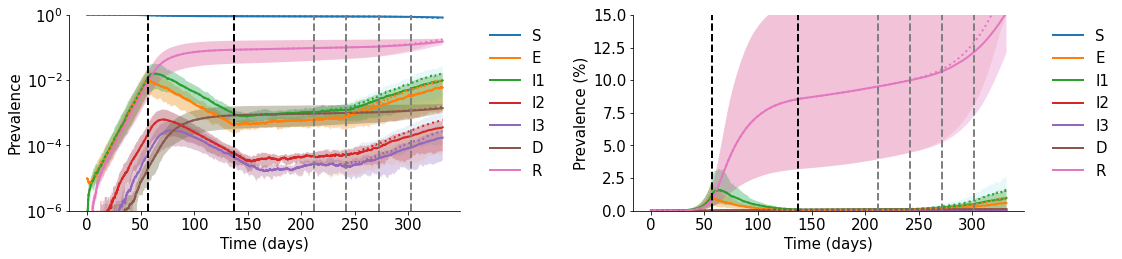

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


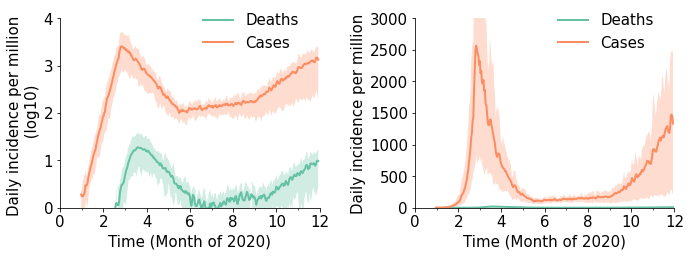

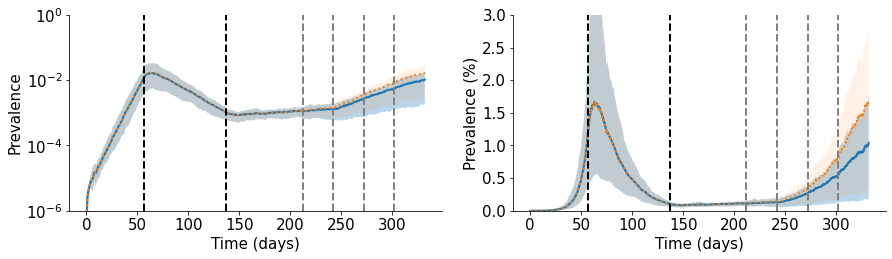

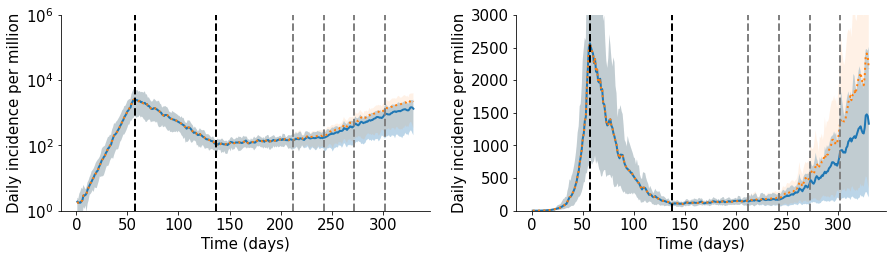

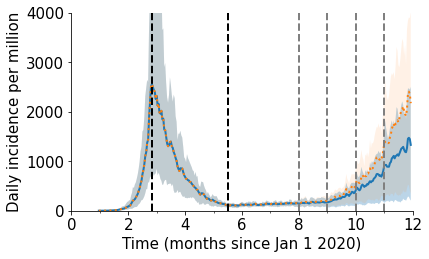

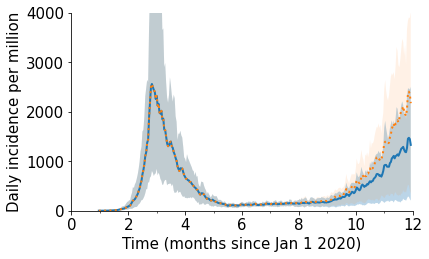

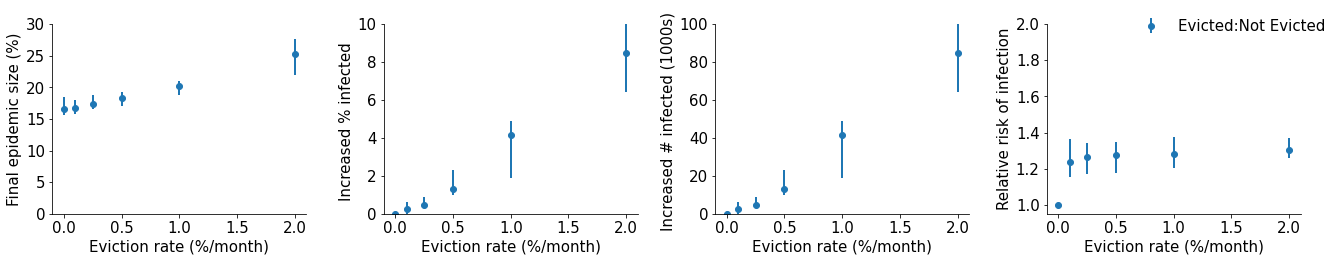

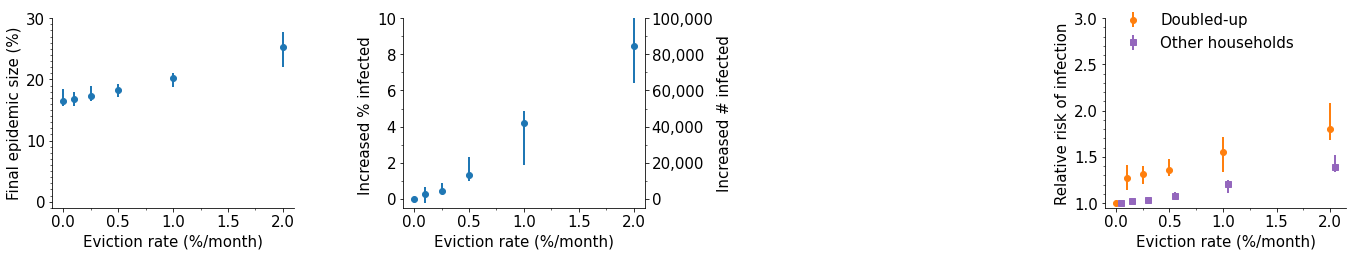



  Eviction     Evictions per
   rate (%)      excess death
-----------  ----------------
       0                  nan
       0.1                115
       0.25               157
       0.5                111
       1                   68
       2                   67


Month        Seroprevalence(%)    Lower IQR(%)    Upper IQR(%)
---------  -------------------  --------------  --------------
April                      0.9             0.5             1
June                       8.1             4.9             9.1
September                  9.4             6              10.5
December                  11.9             9.1            12.8
End                       15.2            13.9            16.4


In [ ]:
thisFolder = "cluster1_comeback" #folder to save things in
soln, soln_cum, tvec, soln_evict, soln_cum_evict, tvec_evict, finalsize=import_data(thisFolder)
evictRate,FinalSizeMed,FinalSizeL,FinalSizeU,delFinalSizeMed,delFinalSizeL,delFinalSizeU,fcFinalSizeMed,fcFinalSizeL,fcFinalSizeU,numDiffFinalSize,delFinalSizeP,RRInfNoMergMed,RRInfNoMergL,RRInfNoMergU,RRInfMergMed,RRInfMergL,RRInfMergU,RREvictMed,RREvictL,RREvictU = list(np.swapaxes(finalsize,0,1))
plot_prevalence_all(ymax=0.15,intOn=1,Tint=c1Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence_case_death(ymax=0.003,Tint=c1Tint)
plot_prevalence(ymax=0.03,intOn=1,Tint=c1Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence(ymax=0.003,intOn=1,Tint=c1Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence2(ymax=0.004,intOn=1,Tint=c1Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3,lockDay = 85)
plot_incidence3(ymax=0.004,intOn=1,Tint=c1Tint,lockDay = 85)
plot_finalsize(Max=30,delMax=10,delAbsMax=100,rrMax=2)
plot_finalsize2(Max=30,delMax=10,rrMax=3)
eviction_deaths(number_backlog = 4, number_merges = 3)
seroprev(Tint=c1Tint, sero_times=np.array((4,6,9,12)))

## Compare to data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/style.py:64: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  [conv.to_rgba(c) for c in colors]


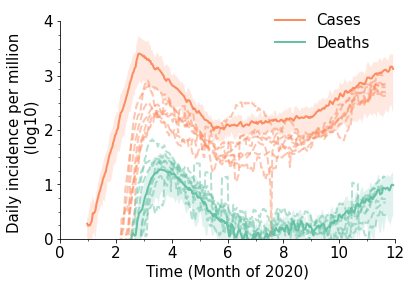

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10


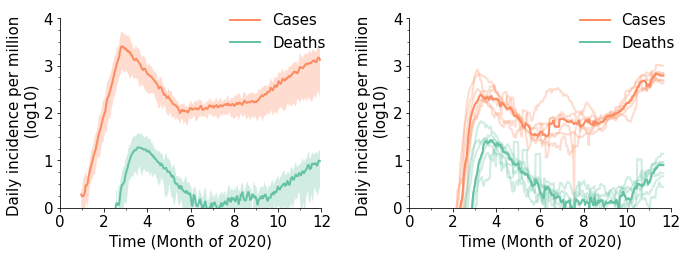

In [ ]:
#thisFolder = "cluster1_comeback" #folder to save things in
plot_incidence_case_death_data1(Tint=c1Tint, lock2 = 0, cluster = 1, lockDay = 85)
plot_incidence_case_death_data2(Tint=c1Tint, lock2 = 0, cluster = 1, lockDay = 85)

## Second lockdown

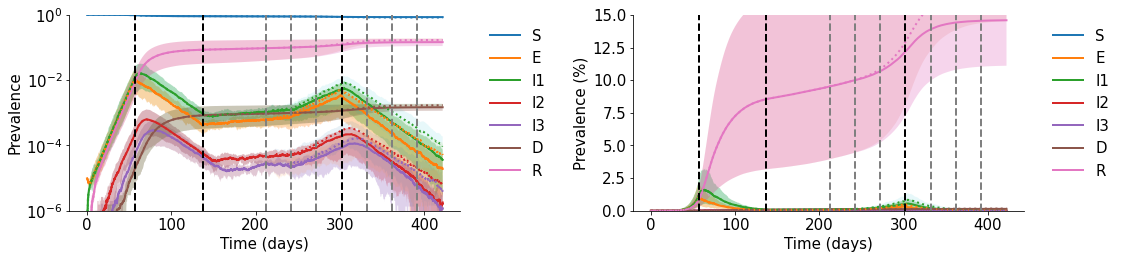

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10


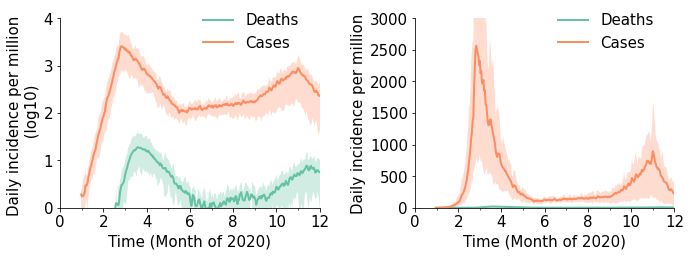

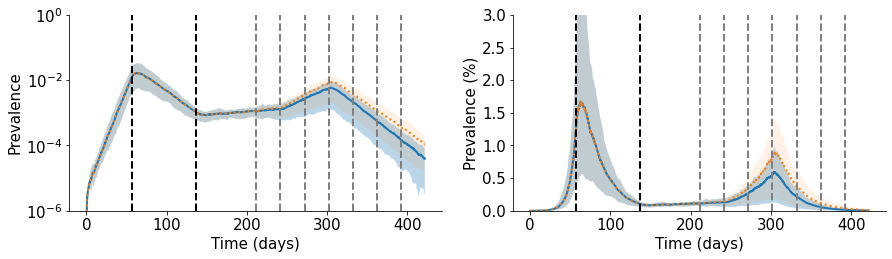

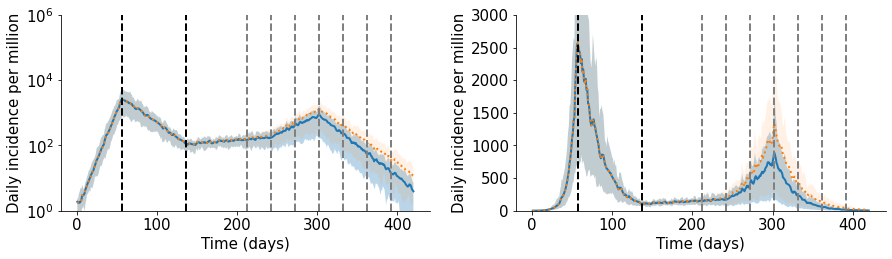

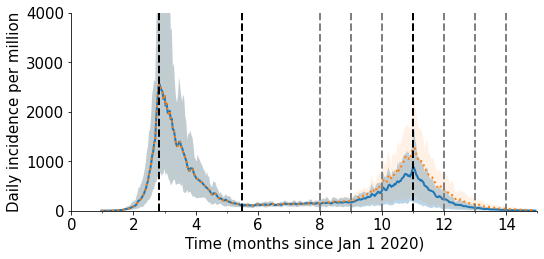

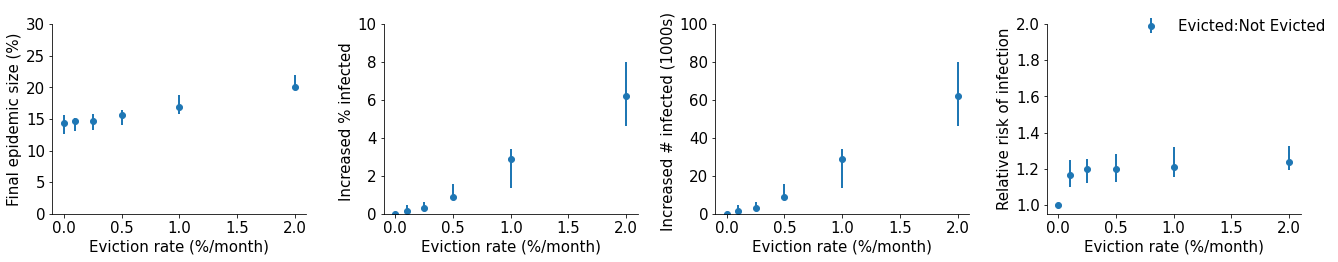

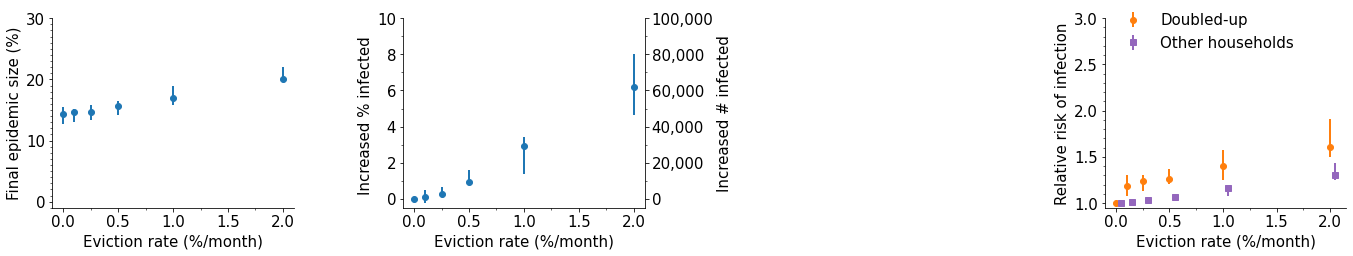



  Eviction     Evictions per
   rate (%)      excess death
-----------  ----------------
       0                  nan
       0.1                329
       0.25               354
       0.5                226
       1                  141
       2                  131


Month        Seroprevalence(%)    Lower IQR(%)    Upper IQR(%)
---------  -------------------  --------------  --------------
April                      0.9             0.5             1
June                       8.1             4.9             9.1
September                  9.4             6              10.5
December                  11.9             9.1            12.8
January                   13.7            11.8            14.6
End                       14.6            13.1            15.6


In [ ]:
 thisFolder = "cluster1_comeback_lock" #folder to save things in
soln, soln_cum, tvec, soln_evict, soln_cum_evict, tvec_evict, finalsize=import_data(thisFolder)
evictRate,FinalSizeMed,FinalSizeL,FinalSizeU,delFinalSizeMed,delFinalSizeL,delFinalSizeU,fcFinalSizeMed,fcFinalSizeL,fcFinalSizeU,numDiffFinalSize,delFinalSizeP,RRInfNoMergMed,RRInfNoMergL,RRInfNoMergU,RRInfMergMed,RRInfMergL,RRInfMergU,RREvictMed,RREvictL,RREvictU = list(np.swapaxes(finalsize,0,1))
plot_prevalence_all(ymax=0.15,intOn=1,Tint=c1Tint,relax=1,Trelax=80,lock2=1,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence_case_death(ymax=0.003,Tint=c1Tint)
plot_prevalence(ymax=0.03,intOn=1,Tint=c1Tint,relax=1,Trelax=80,lock2=0,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence(ymax=0.003,intOn=1,Tint=c1Tint,relax=1,Trelax=80,lock2=0,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence2(ymax=0.004,intOn=1,Tint=c1Tint,relax=1,Trelax=80,lock2=1,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6,lockDay = 85)
plot_finalsize(Max=30,delMax=10,delAbsMax=100,rrMax=2)
plot_finalsize2(Max=30,delMax=10,rrMax=3)
eviction_deaths(number_backlog = 4, number_merges = 6)
seroprev(Tint=c1Tint, sero_times=np.array((4,6,9,12,13)))

# Group 2

## Comeback

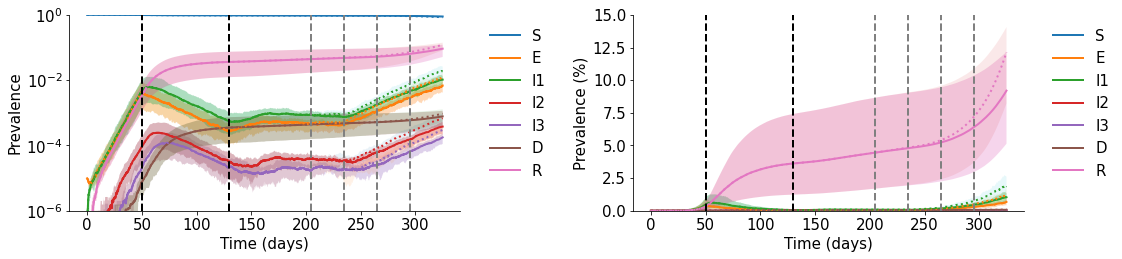

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


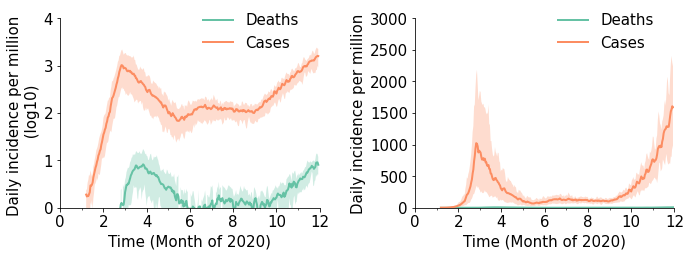

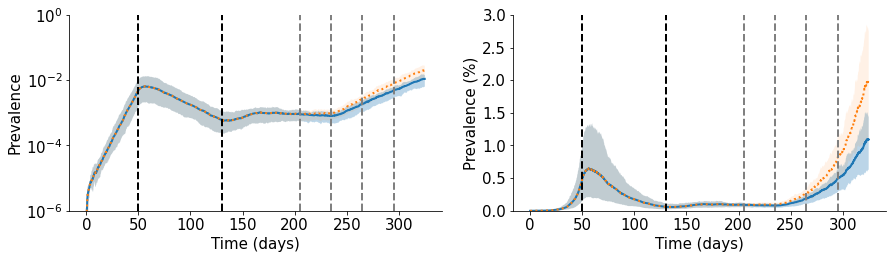

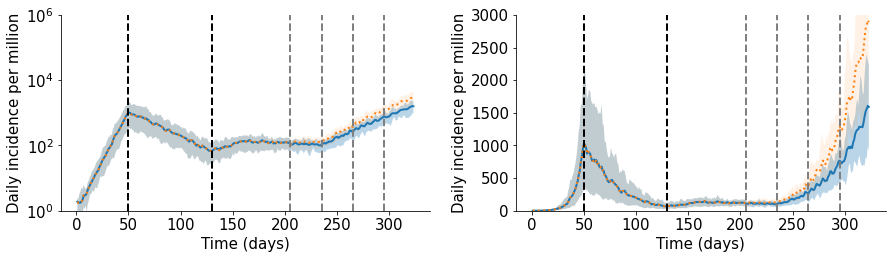

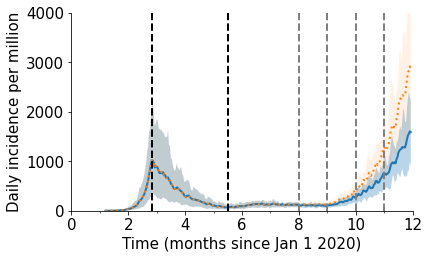

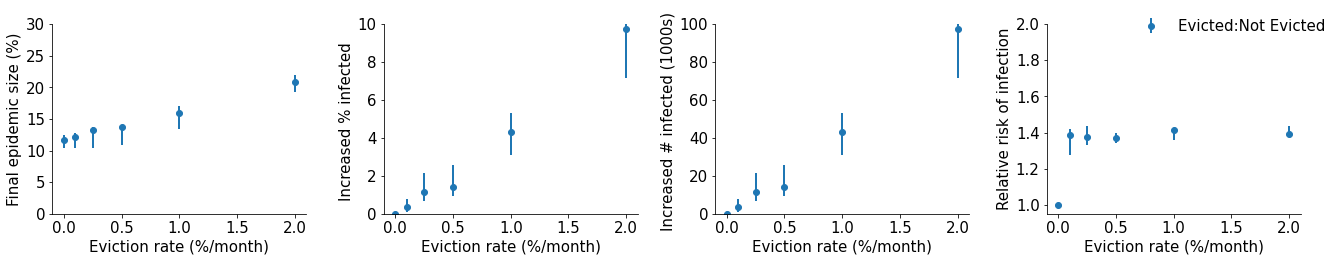

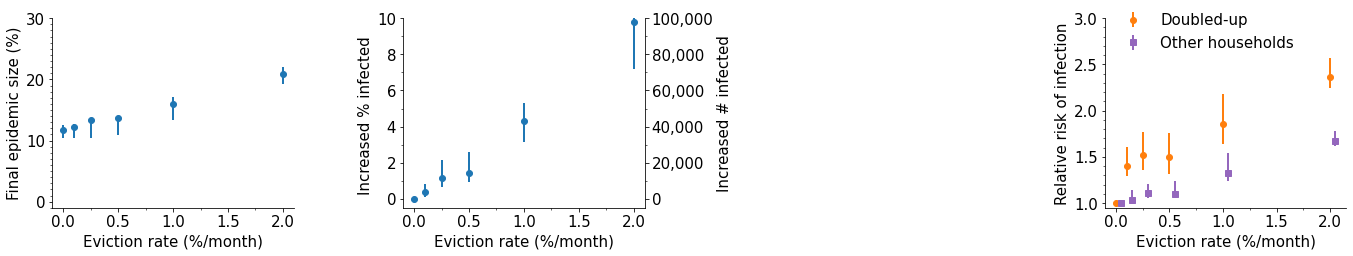



  Eviction     Evictions per
   rate (%)      excess death
-----------  ----------------
       0                  nan
       0.1                 76
       0.25                62
       0.5                102
       1                   66
       2                   58


Month        Seroprevalence(%)    Lower IQR(%)    Upper IQR(%)
---------  -------------------  --------------  --------------
April                      0.3             0.2             0.4
June                       3.4             2               3.6
September                  4.4             2.7             4.8
December                   6.1             4.5             7
End                        9.2             8.4            10.5


In [ ]:
thisFolder = "cluster2_comeback" #folder to save things in
soln, soln_cum, tvec, soln_evict, soln_cum_evict, tvec_evict, finalsize=import_data(thisFolder)
evictRate,FinalSizeMed,FinalSizeL,FinalSizeU,delFinalSizeMed,delFinalSizeL,delFinalSizeU,fcFinalSizeMed,fcFinalSizeL,fcFinalSizeU,numDiffFinalSize,delFinalSizeP,RRInfNoMergMed,RRInfNoMergL,RRInfNoMergU,RRInfMergMed,RRInfMergL,RRInfMergU,RREvictMed,RREvictL,RREvictU = list(np.swapaxes(finalsize,0,1))
plot_prevalence_all(ymax=0.15,intOn=1,Tint=c2Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence_case_death(ymax=0.003,Tint=c2Tint)
plot_prevalence(ymax=0.03,intOn=1,Tint=c2Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence(ymax=0.003,intOn=1,Tint=c2Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence2(ymax=0.004,intOn=1,Tint=c2Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3,lockDay = 85)
plot_finalsize(Max=30,delMax=10,delAbsMax=100,rrMax=2)
plot_finalsize2(Max=30,delMax=10,rrMax=3)
eviction_deaths(number_backlog = 4, number_merges = 3)
seroprev(Tint=c2Tint, sero_times=np.array((4,6,9,12)))

## Compare to data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


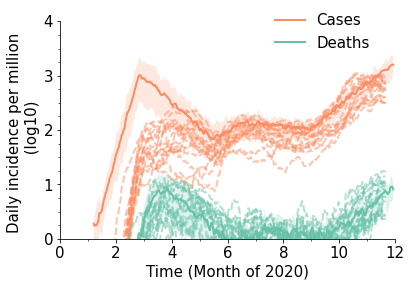

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10


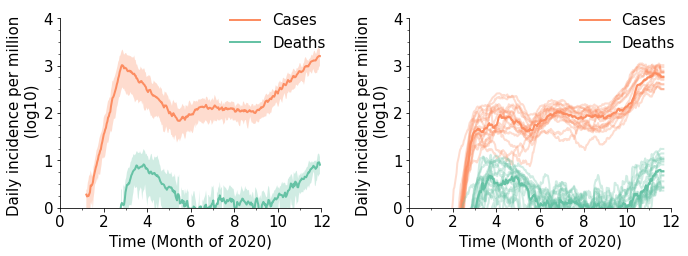

In [ ]:
#thisFolder = "cluster1_comeback" #folder to save things in
plot_incidence_case_death_data1(Tint=c2Tint, lock2 = 0, cluster = 2, lockDay = 85)
plot_incidence_case_death_data2(Tint=c2Tint, lock2 = 0, cluster = 2, lockDay = 85)

## Second lockdown

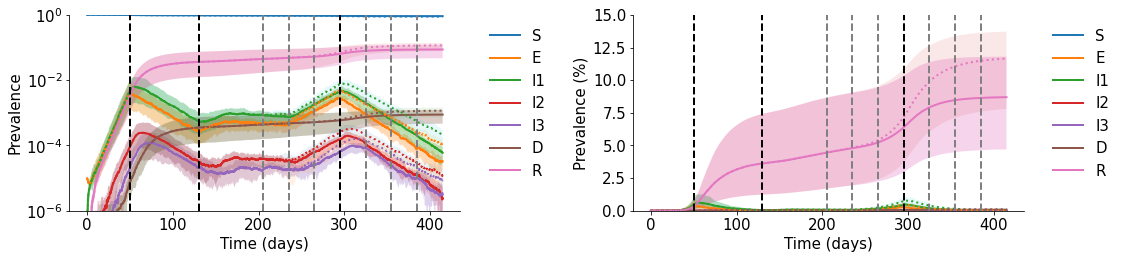

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


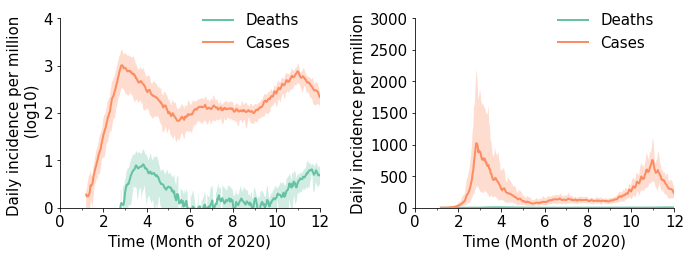

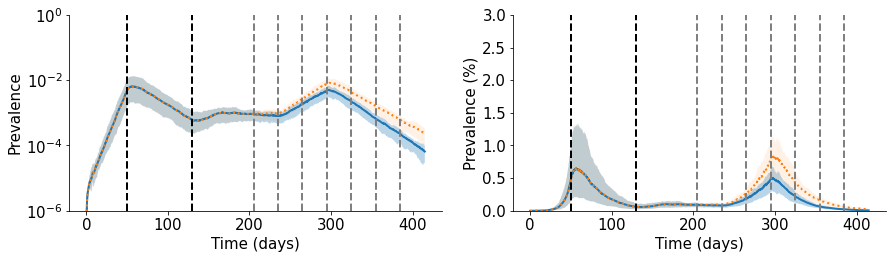

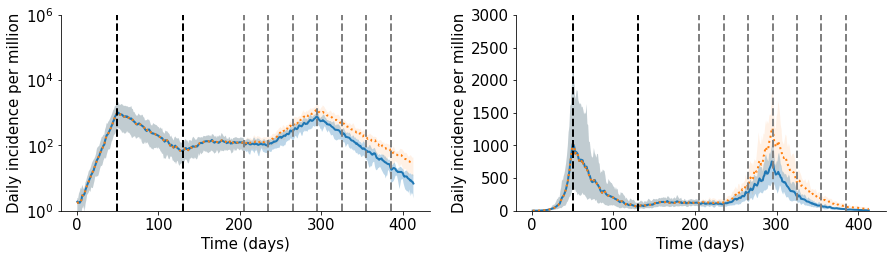

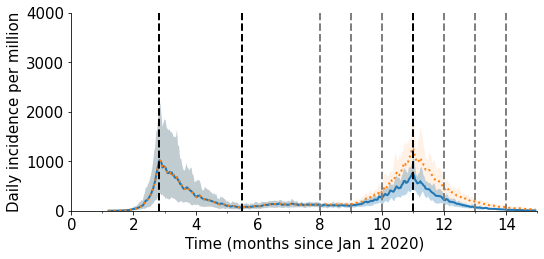

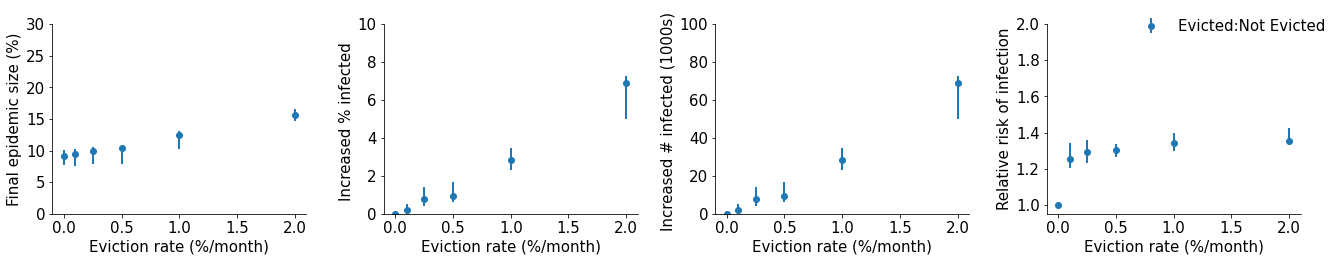

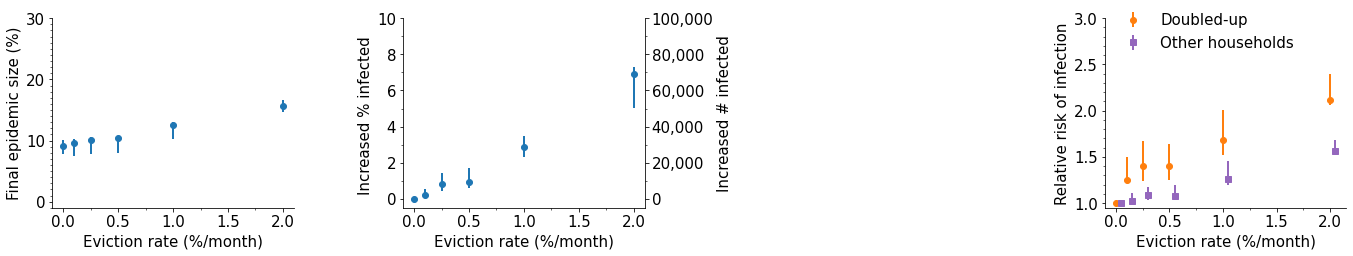



  Eviction     Evictions per
   rate (%)      excess death
-----------  ----------------
       0                  nan
       0.1                225
       0.25               127
       0.5                219
       1                  143
       2                  118


Month        Seroprevalence(%)    Lower IQR(%)    Upper IQR(%)
---------  -------------------  --------------  --------------
April                      0.3             0.2             0.4
June                       3.4             2               3.6
September                  4.4             2.7             4.8
December                   6.1             4.5             7
January                    7.7             6.6             8.9
End                        8.7             7.8            10


In [ ]:
 thisFolder = "cluster2_comeback_lock" #folder to save things in
soln, soln_cum, tvec, soln_evict, soln_cum_evict, tvec_evict, finalsize=import_data(thisFolder)
evictRate,FinalSizeMed,FinalSizeL,FinalSizeU,delFinalSizeMed,delFinalSizeL,delFinalSizeU,fcFinalSizeMed,fcFinalSizeL,fcFinalSizeU,numDiffFinalSize,delFinalSizeP,RRInfNoMergMed,RRInfNoMergL,RRInfNoMergU,RRInfMergMed,RRInfMergL,RRInfMergU,RREvictMed,RREvictL,RREvictU = list(np.swapaxes(finalsize,0,1))
plot_prevalence_all(ymax=0.15,intOn=1,Tint=c2Tint,relax=1,Trelax=80,lock2=1,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence_case_death(ymax=0.003,Tint=c2Tint)
plot_prevalence(ymax=0.03,intOn=1,Tint=c2Tint,relax=1,Trelax=80,lock2=0,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence(ymax=0.003,intOn=1,Tint=c2Tint,relax=1,Trelax=80,lock2=0,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence2(ymax=0.004,intOn=1,Tint=c2Tint,relax=1,Trelax=80,lock2=1,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6,lockDay = 85)
plot_finalsize(Max=30,delMax=10,delAbsMax=100,rrMax=2)
plot_finalsize2(Max=30,delMax=10,rrMax=3)
eviction_deaths(number_backlog = 4, number_merges = 6)
seroprev(Tint=c2Tint, sero_times=np.array((4,6,9,12,13)))

# Group 3

## Comeback

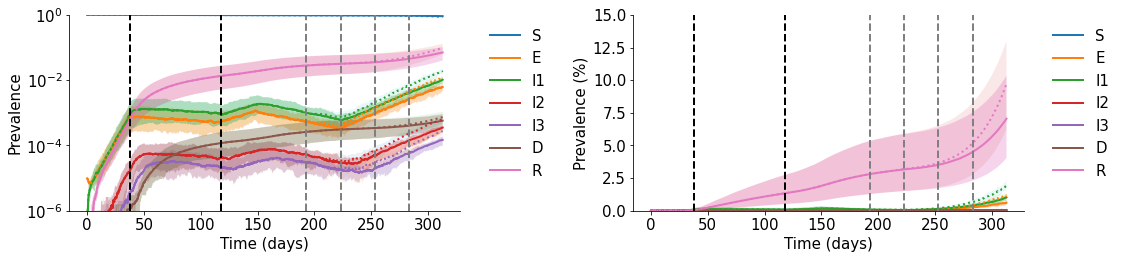

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


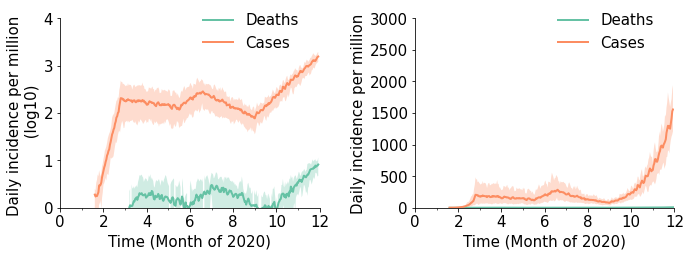

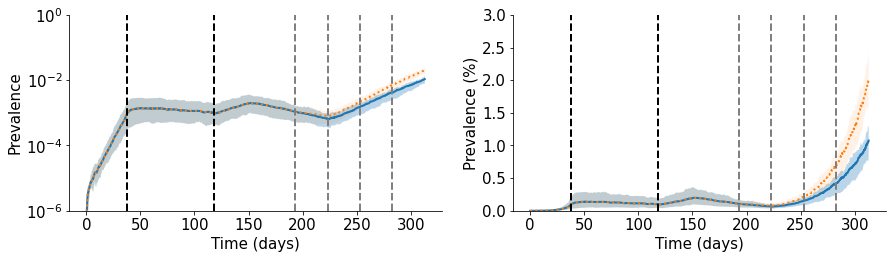

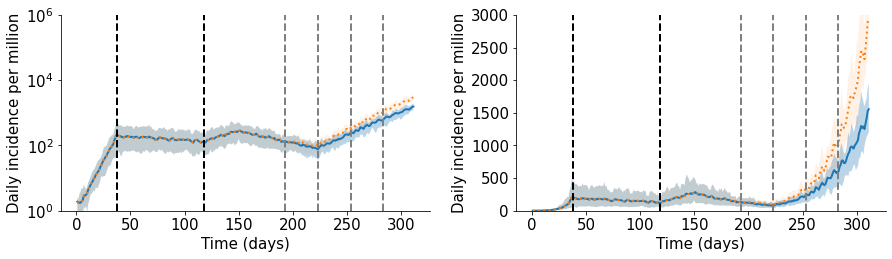

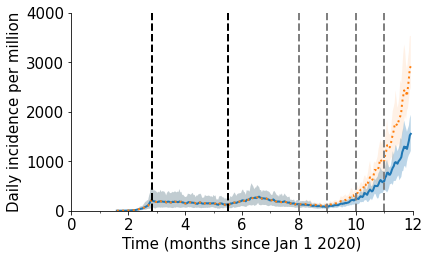

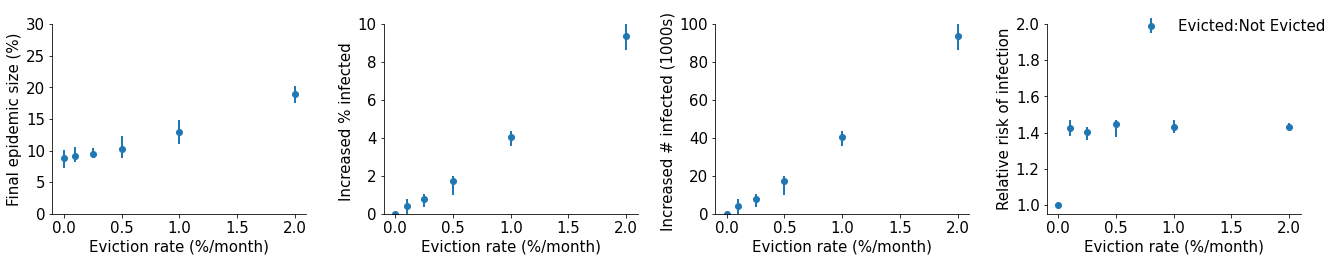

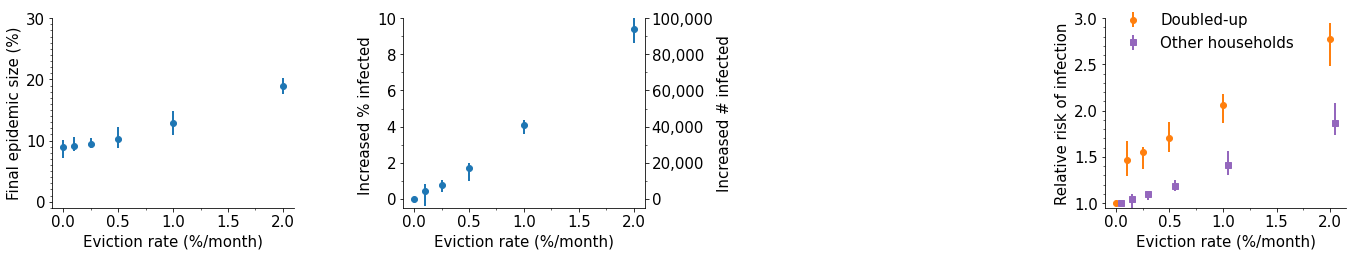



  Eviction     Evictions per
   rate (%)      excess death
-----------  ----------------
       0                  nan
       0.1                 70
       0.25                94
       0.5                 83
       1                   70
       2                   61


Month        Seroprevalence(%)    Lower IQR(%)    Upper IQR(%)
---------  -------------------  --------------  --------------
April                      0.1             0               0.1
June                       1.1             0.7             1.1
September                  2.7             1.9             2.8
December                   4.3             3.2             4.6
End                        7.1             5.8             7.9


In [ ]:
thisFolder = "cluster3_comeback" #folder to save things in
soln, soln_cum, tvec, soln_evict, soln_cum_evict, tvec_evict, finalsize=import_data(thisFolder)
evictRate,FinalSizeMed,FinalSizeL,FinalSizeU,delFinalSizeMed,delFinalSizeL,delFinalSizeU,fcFinalSizeMed,fcFinalSizeL,fcFinalSizeU,numDiffFinalSize,delFinalSizeP,RRInfNoMergMed,RRInfNoMergL,RRInfNoMergU,RRInfMergMed,RRInfMergL,RRInfMergU,RREvictMed,RREvictL,RREvictU = list(np.swapaxes(finalsize,0,1))
plot_prevalence_all(ymax=0.15,intOn=1,Tint=c3Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence_case_death(ymax=0.003,Tint=c3Tint)
plot_prevalence(ymax=0.03,intOn=1,Tint=c3Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence(ymax=0.003,intOn=1,Tint=c3Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence2(ymax=0.004,intOn=1,Tint=c3Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3,lockDay = 85)
plot_finalsize(Max=30,delMax=10,delAbsMax=100,rrMax=2)
plot_finalsize2(Max=30,delMax=10,rrMax=3)
eviction_deaths(number_backlog = 4, number_merges = 3)
seroprev(Tint=c3Tint, sero_times=np.array((4,6,9,12)))

## Compare to data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


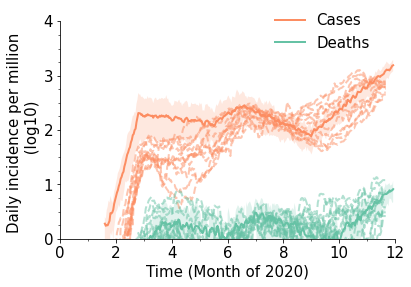

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10


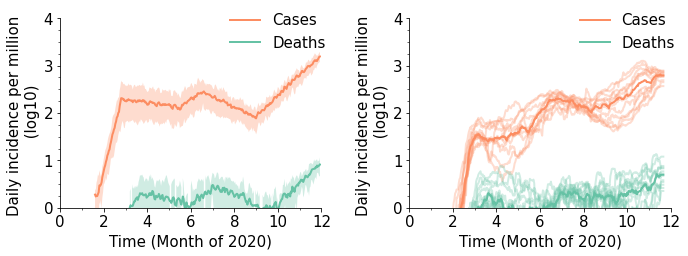

In [ ]:
#thisFolder = "cluster1_comeback" #folder to save things in
plot_incidence_case_death_data1(Tint=c3Tint, lock2 = 0, cluster = 3, lockDay = 85)
plot_incidence_case_death_data2(Tint=c3Tint, lock2 = 0, cluster = 3, lockDay = 85)

## Second lockdown

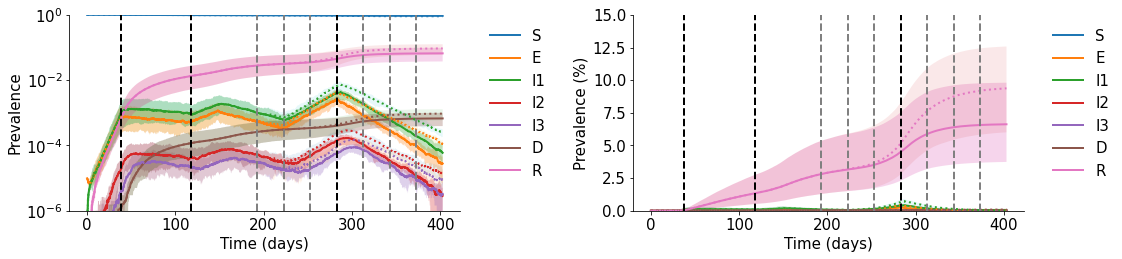

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


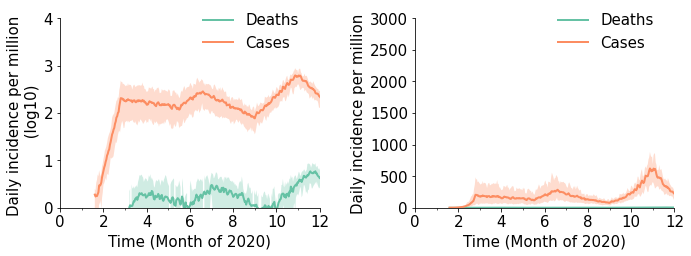

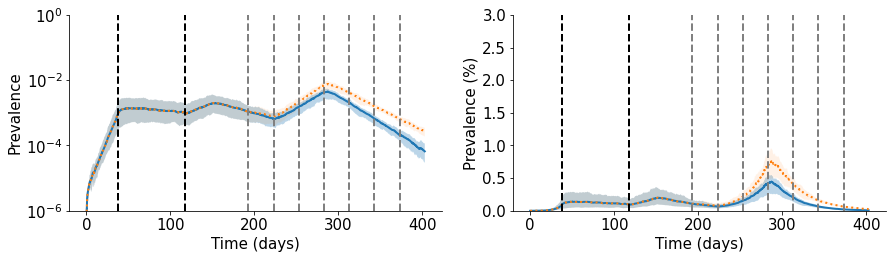

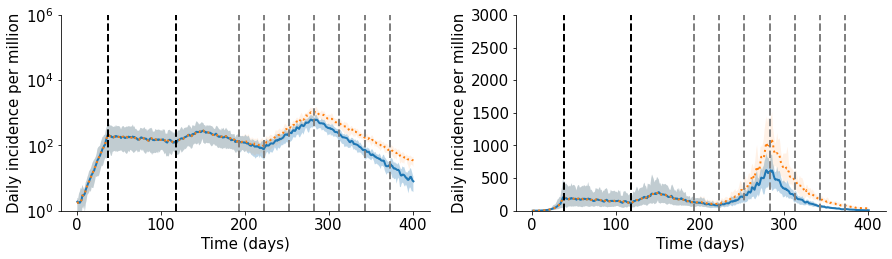

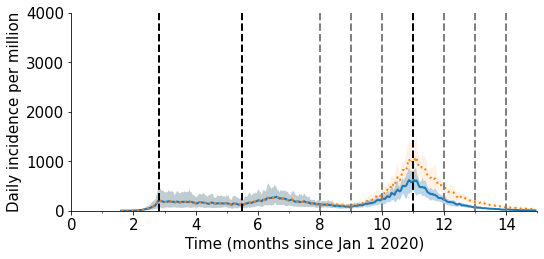

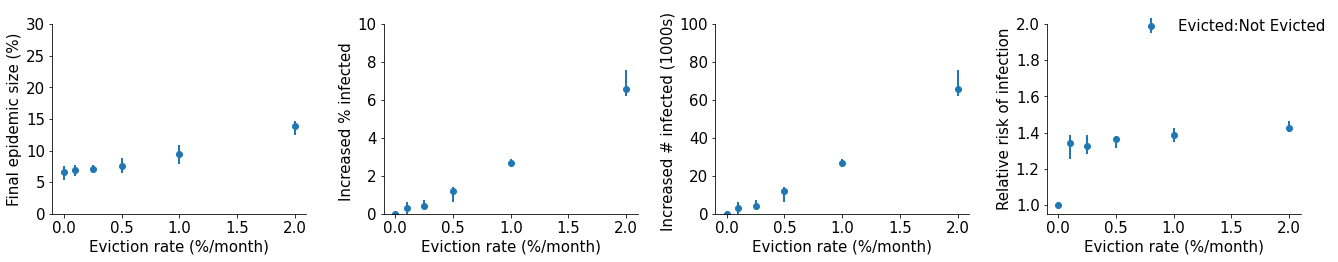

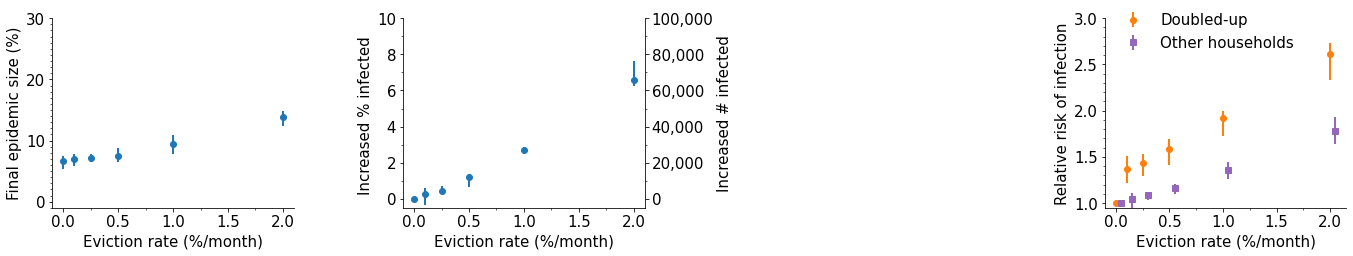



  Eviction     Evictions per
   rate (%)      excess death
-----------  ----------------
       0                  nan
       0.1                141
       0.25               237
       0.5                172
       1                  152
       2                  124


Month        Seroprevalence(%)    Lower IQR(%)    Upper IQR(%)
---------  -------------------  --------------  --------------
April                      0.1             0               0.1
June                       1.1             0.7             1.1
September                  2.7             1.9             2.8
December                   4.3             3.2             4.6
January                    5.7             4.6             6.4
End                        6.6             5.5             7.4


In [ ]:
 thisFolder = "cluster3_comeback_lock" #folder to save things in
soln, soln_cum, tvec, soln_evict, soln_cum_evict, tvec_evict, finalsize=import_data(thisFolder)
evictRate,FinalSizeMed,FinalSizeL,FinalSizeU,delFinalSizeMed,delFinalSizeL,delFinalSizeU,fcFinalSizeMed,fcFinalSizeL,fcFinalSizeU,numDiffFinalSize,delFinalSizeP,RRInfNoMergMed,RRInfNoMergL,RRInfNoMergU,RRInfMergMed,RRInfMergL,RRInfMergU,RREvictMed,RREvictL,RREvictU = list(np.swapaxes(finalsize,0,1))
plot_prevalence_all(ymax=0.15,intOn=1,Tint=c3Tint,relax=1,Trelax=80,lock2=1,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence_case_death(ymax=0.003,Tint=c3Tint)
plot_prevalence(ymax=0.03,intOn=1,Tint=c3Tint,relax=1,Trelax=80,lock2=0,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence(ymax=0.003,intOn=1,Tint=c3Tint,relax=1,Trelax=80,lock2=0,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence2(ymax=0.004,intOn=1,Tint=c3Tint,relax=1,Trelax=80,lock2=1,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6,lockDay = 85)
plot_finalsize(Max=30,delMax=10,delAbsMax=100,rrMax=2)
plot_finalsize2(Max=30,delMax=10,rrMax=3)
eviction_deaths(number_backlog = 4, number_merges = 6)
seroprev(Tint=c3Tint, sero_times=np.array((4,6,9,12,13)))

# Group 4

## Comeback

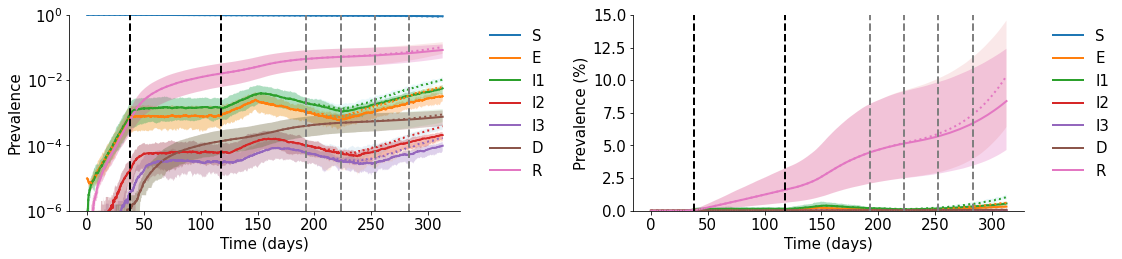

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


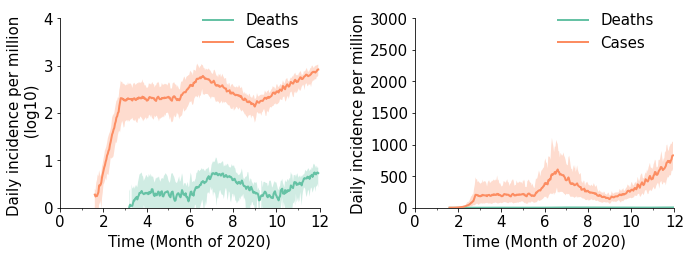

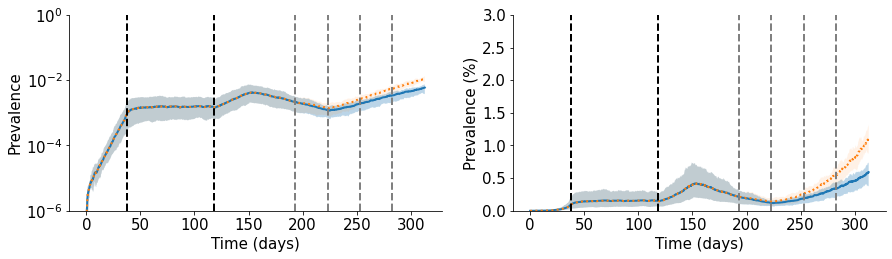

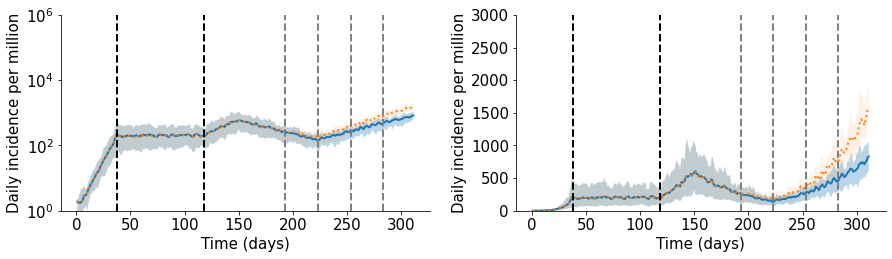

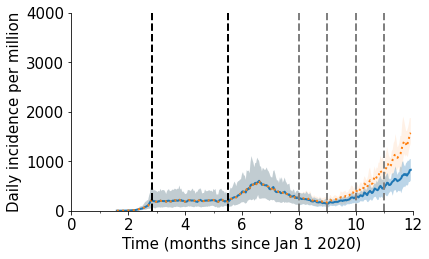

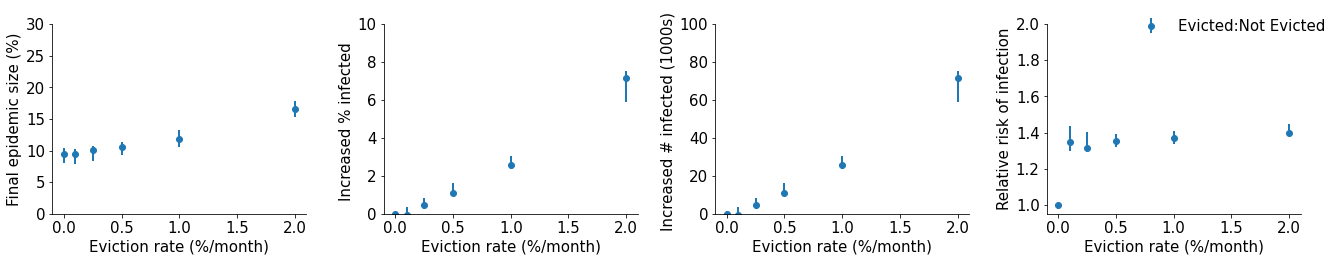

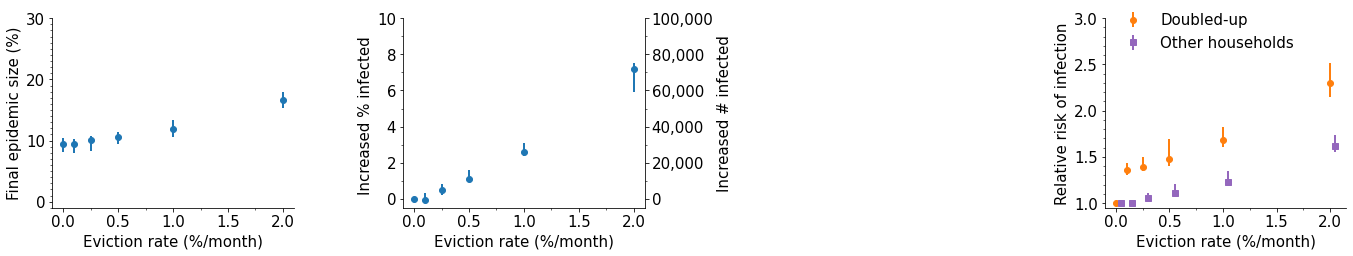



  Eviction     Evictions per
   rate (%)      excess death
-----------  ----------------
       0                  nan
       0.1                inf
       0.25               151
       0.5                132
       1                  111
       2                   80


Month        Seroprevalence(%)    Lower IQR(%)    Upper IQR(%)
---------  -------------------  --------------  --------------
April                      0.1             0               0.1
June                       1.2             0.8             1.2
September                  4.3             3.1             4.4
December                   6.5             5               6.9
End                        8.4             7.2             9.2


In [ ]:
thisFolder = "cluster4_comeback" #folder to save things in
soln, soln_cum, tvec, soln_evict, soln_cum_evict, tvec_evict, finalsize=import_data(thisFolder)
evictRate,FinalSizeMed,FinalSizeL,FinalSizeU,delFinalSizeMed,delFinalSizeL,delFinalSizeU,fcFinalSizeMed,fcFinalSizeL,fcFinalSizeU,numDiffFinalSize,delFinalSizeP,RRInfNoMergMed,RRInfNoMergL,RRInfNoMergU,RRInfMergMed,RRInfMergL,RRInfMergU,RREvictMed,RREvictL,RREvictU = list(np.swapaxes(finalsize,0,1))
plot_prevalence_all(ymax=0.15,intOn=1,Tint=c4Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence_case_death(ymax=0.003,Tint=c4Tint)
plot_prevalence(ymax=0.03,intOn=1,Tint=c4Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence(ymax=0.003,intOn=1,Tint=c4Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3)
plot_incidence2(ymax=0.004,intOn=1,Tint=c4Tint,relax=1,Trelax=80,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 3,lockDay = 85)
plot_finalsize(Max=30,delMax=10,delAbsMax=100,rrMax=2)
plot_finalsize2(Max=30,delMax=10,rrMax=3)
eviction_deaths(number_backlog = 4, number_merges = 3)
seroprev(Tint=c4Tint, sero_times=np.array((4,6,9,12)))

## Compare to data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


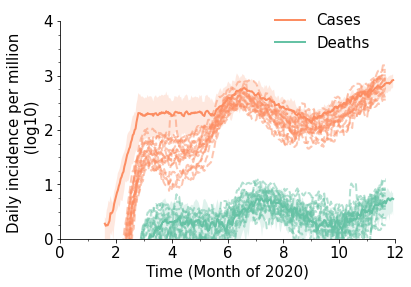

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10


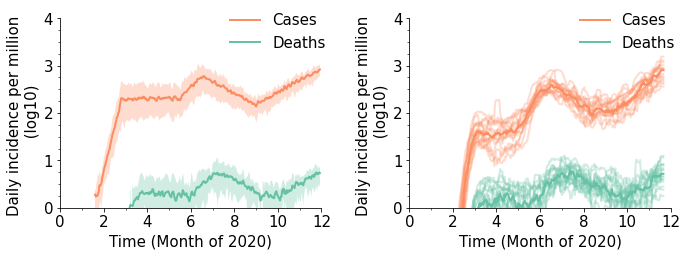

In [ ]:
#thisFolder = "cluster1_comeback" #folder to save things in
plot_incidence_case_death_data1(Tint=c4Tint, lock2 = 0, cluster = 4, lockDay = 85)
plot_incidence_case_death_data2(Tint=c4Tint, lock2 = 0, cluster = 4, lockDay = 85)

## Second lockdown

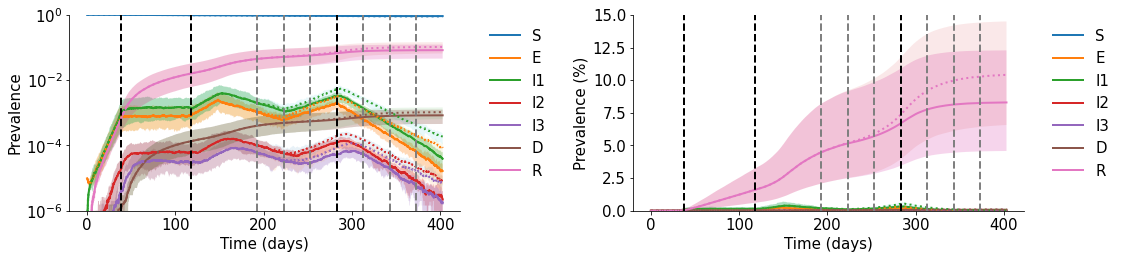

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


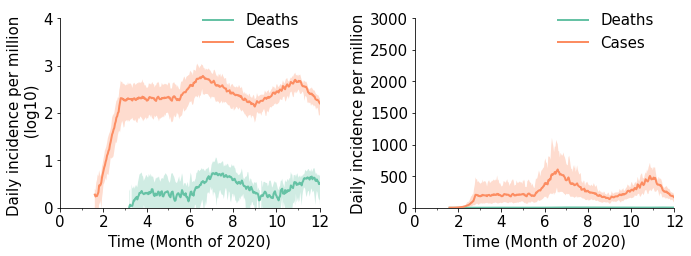

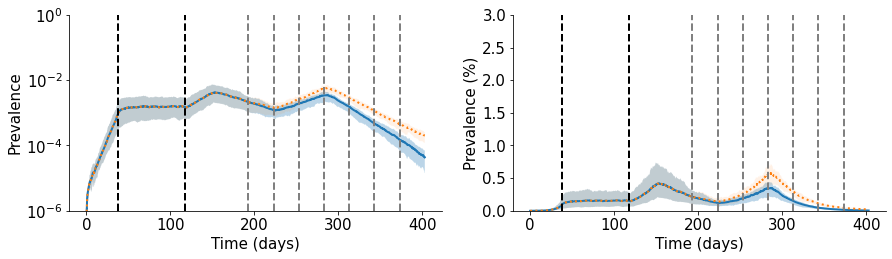

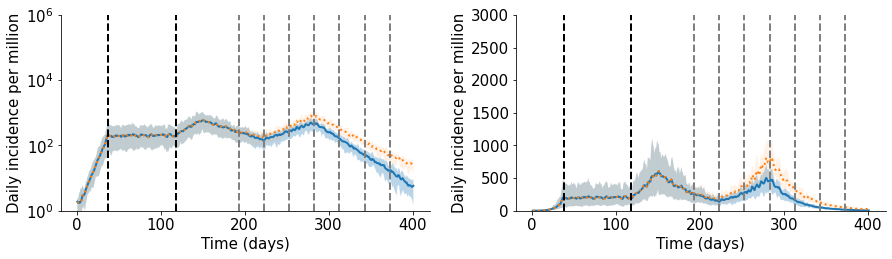

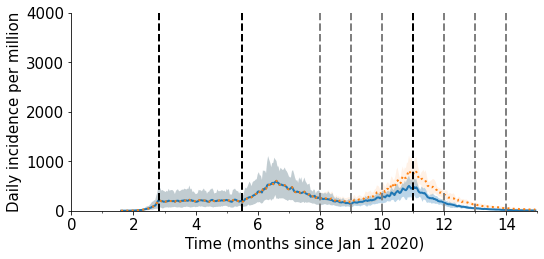

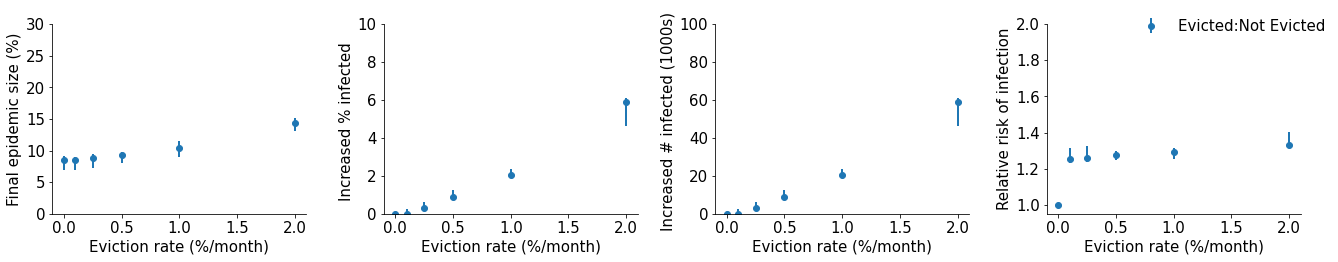

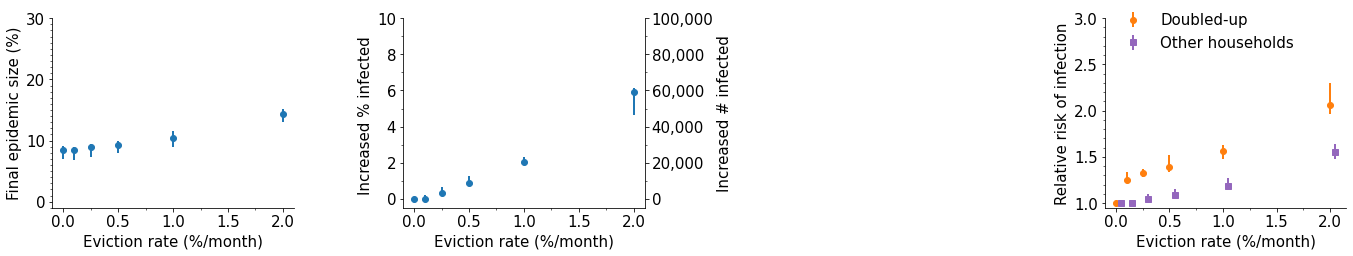



  Eviction     Evictions per
   rate (%)      excess death
-----------  ----------------
       0                  nan
       0.1                inf
       0.25               309
       0.5                230
       1                  200
       2                  139


Month        Seroprevalence(%)    Lower IQR(%)    Upper IQR(%)
---------  -------------------  --------------  --------------
April                      0.1             0               0.1
June                       1.2             0.8             1.2
September                  4.3             3.1             4.4
December                   6.5             5               6.9
January                    7.6             6.3             8.3
End                        8.3             7               9


In [ ]:
 thisFolder = "cluster4_comeback_lock" #folder to save things in
soln, soln_cum, tvec, soln_evict, soln_cum_evict, tvec_evict, finalsize=import_data(thisFolder)
evictRate,FinalSizeMed,FinalSizeL,FinalSizeU,delFinalSizeMed,delFinalSizeL,delFinalSizeU,fcFinalSizeMed,fcFinalSizeL,fcFinalSizeU,numDiffFinalSize,delFinalSizeP,RRInfNoMergMed,RRInfNoMergL,RRInfNoMergU,RRInfMergMed,RRInfMergL,RRInfMergU,RREvictMed,RREvictL,RREvictU = list(np.swapaxes(finalsize,0,1))
plot_prevalence_all(ymax=0.15,intOn=1,Tint=c4Tint,relax=1,Trelax=80,lock2=1,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence_case_death(ymax=0.003,Tint=c4Tint)
plot_prevalence(ymax=0.03,intOn=1,Tint=c4Tint,relax=1,Trelax=80,lock2=0,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence(ymax=0.003,intOn=1,Tint=c4Tint,relax=1,Trelax=80,lock2=0,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6)
plot_incidence2(ymax=0.004,intOn=1,Tint=c4Tint,relax=1,Trelax=80,lock2=1,Tlock2=5.5*30,evict=1,T_start_merge=75,T_int_merge = 30,number_merges = 6,lockDay = 85)
plot_finalsize(Max=30,delMax=10,delAbsMax=100,rrMax=2)
plot_finalsize2(Max=30,delMax=10,rrMax=3)
eviction_deaths(number_backlog = 4, number_merges = 6)
seroprev(Tint=c4Tint, sero_times=np.array((4,6,9,12,13)))